### Тестирование психического здоровья

В данных содержатся ответы скольки-то людей на тесты на наличие депрессии, особенности характера и грамотность??, а также их персональные данные.

В ходе работы с данными выполнены следующие задачи:

- [ ] очистка данных от выбросов и ошибок
- [ ] предложена простая модель оценки депрессивности на основе теста Q
- [ ] проанализированы связи между уровнем депрессивности и особенностями характера
- [ ] проанализированы свсязи между возрастом, образованием и другими личными данными и результатами психологических тестов
- [ ] 
- [ ] 
- [ ] 



In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [93]:
file1=pd.read_csv('data.csv', sep='\t')

### Описание данных

**1. Тест DASS** - включает в себя 42 вопроса, каждый из которых ориентирован на диагностику уровня депрессии, тревоги или стресса. В каждом вопросе дано утверждение и предлагается оценить, насколько часто описанное состояние возникает у тестируемого.

**2. Тест TIPI** - предложено 10 черт характера, для каждого необходимо оценить, как сильно оно характерно для тестируемого.

**3. Тест VCL** - необходимо отметить среди 16 слов те, значение которых участник точно знает

**4. Персональные данные** (возраст, уровень образования, данные об устройстве, с которого проходили тест, и др.)

In [3]:
file1.columns

Index(['Q1A', 'Q1I', 'Q1E', 'Q2A', 'Q2I', 'Q2E', 'Q3A', 'Q3I', 'Q3E', 'Q4A',
       ...
       'age', 'screensize', 'uniquenetworklocation', 'hand', 'religion',
       'race', 'voted', 'married', 'familysize', 'major'],
      dtype='object', length=171)

In [6]:
file1[file1['uniquenetworklocation']==2][['Q'+str(_) + 'A' for _ in range(1,43)]]

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q33A,Q34A,Q35A,Q36A,Q37A,Q38A,Q39A,Q40A,Q41A,Q42A
4,2,2,3,4,4,2,4,4,4,3,...,4,4,3,4,3,3,3,4,4,3
30,2,2,3,1,3,3,1,3,2,2,...,3,3,2,2,3,3,2,3,1,2
47,4,1,4,3,3,4,2,4,4,3,...,4,4,3,3,2,4,3,4,2,2
48,4,1,4,2,3,4,1,4,3,1,...,3,3,3,3,2,2,1,4,1,4
66,1,2,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39754,2,1,1,1,2,1,1,2,2,2,...,4,3,1,1,3,3,1,2,1,4
39756,4,2,3,2,3,1,1,1,3,3,...,2,4,2,3,3,3,3,2,1,2
39757,4,1,3,1,2,3,1,2,3,4,...,1,4,3,2,3,3,2,1,2,3
39759,2,1,2,1,2,1,2,3,1,2,...,4,3,2,2,2,2,3,3,1,4


In [19]:
mask=file1.duplicated(subset=list(file1.columns[157:162])+list(file1.columns[164:171]))
file1.loc[mask, 'age'].describe()

count    3808.000000
mean       18.134454
std         3.764724
min        13.000000
25%        16.000000
50%        18.000000
75%        19.000000
max        75.000000
Name: age, dtype: float64

### Очистка данных

##### Проверим наличие пропущенных данных (датасет слишком большой чтобы использовать info())

In [3]:
file1.shape

(39775, 171)

In [4]:
pd.options.display.max_info_columns

100

In [13]:
n=file1.shape[0]
for col in file1.columns:
    a=file1[col].isnull().value_counts()[False]
    if a!=n:
        print(col, n-a)

country 2
major 11403


In [94]:
file1['major']=file1['major'].fillna('no')
file1['country']=file1['country'].fillna('no')

### Выбросы и опечатки

#### Тест DASS

***Q_i_A*** - ответ на i вопрос от 1 до 4, где 1 - никогда, 4 - очень часто или постоянно. Вопросы делятся на 3 группы, измеряющие уровень стресса, тревоги и депрессии. Вопросы из каждой группы:

стресс - 1,6,8,11,12,14,18,

тревога - 2,4,7,9, 15,19,20

депрессия - 3,5,10,13,16,17,21


***Q_i_E*** - количество милисекунд, потраченных на ответ на i вопрос

***Q_i_I*** - порядковый номер i вопроса для данного участника

***introelapse*** - время в секундах, потраченное на начальную страницу

***testelapse*** - время в секундах, потраченное на весь тест	

***surveyelapse***	- время, потраченное на вопросы о личных данных и другие тесты


In [95]:
def find_err(df, values):
    bad_ans=[]
    for col in df.columns:
        bad_ans+=(list(df[~df[col].isin(values)].index))
    return bad_ans

In [96]:
find_err(file1[['Q'+str(i)+'A' for i in range(1,43)]], range(1,5))

[]

In [97]:
#Переведём время ответов в секунды
file1[['Q'+str(i)+'E' for i in range(1,43)]]=file1[['Q'+str(i)+'E' for i in range(1,43)]]/1000

In [98]:
file1['testelapse'].describe() #нет отрицательных значений, есть явные выбросы

count    3.977500e+04
mean     2.684843e+03
std      1.482418e+05
min      1.200000e+01
25%      1.650000e+02
50%      2.130000e+02
75%      2.960000e+02
max      2.082972e+07
Name: testelapse, dtype: float64

In [10]:
qe_names=['Q'+str(_) + 'E' for _ in range(1,43)]

In [9]:
file1[qe_names].describe() #есть отрицательные значения - поменяем на противоположные
#есть явные выбросы

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q33E,Q34E,Q35E,Q36E,Q37E,Q38E,Q39E,Q40E,Q41E,Q42E
count,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,...,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000
mean,6.970591,5.332376,7.426446,7.128728,5.919306,5.724097,9.776971,4.444627,18.330829,9.157494,...,5.272239,4.871684,14.105871,4.335748,6.811023,5.838114,8.472124,10.274100,5.540696,8.300695
std,86.705132,26.513611,158.702353,75.984858,64.282067,50.195831,442.758756,22.916182,1409.724444,418.635469,...,51.466986,108.623401,376.000379,30.703420,76.601331,301.126024,168.614116,320.856859,59.782867,77.650779
min,0.180000,0.176000,-10.814000,0.176000,0.178000,0.178000,0.178000,0.179000,0.177000,-19.695000,...,0.179000,-1.615000,0.183000,0.178000,-0.165000,-8.921000,-0.144000,0.178000,-0.159000,0.178000
25%,2.664000,2.477000,2.857000,2.949000,2.327000,2.369000,2.641500,2.104500,4.218000,2.427000,...,2.162000,1.922000,4.317500,1.681000,2.883000,1.897000,2.130500,3.393500,2.237000,3.070000
50%,3.609000,3.511000,3.898000,4.258000,3.237000,3.248000,3.702000,2.871000,6.139000,3.375000,...,2.993000,2.653000,6.499000,2.254000,4.054000,2.602000,2.930000,4.629000,3.052000,4.373000
75%,5.358000,5.216000,5.766000,6.285000,4.849000,4.788000,5.362000,4.239500,9.245000,5.027000,...,4.608000,4.003500,10.388000,3.484000,5.924000,3.934500,4.940000,6.733000,4.518000,6.681000
max,12102.282000,2161.057000,28582.689000,9488.330000,9467.497000,5426.858000,74124.488000,2103.626000,279772.213000,74471.124000,...,8658.903000,21328.973000,72970.668000,4133.123000,12710.289000,59401.008000,31773.217000,56297.555000,8021.110000,7750.098000


In [99]:
for col in qe_names:
    file1.loc[file1[col]<0, col]*=-1

In [100]:
file1['total_time']=file1[qe_names].sum(axis=1)

In [13]:
file1['total_time'].describe()

count     39775.000000
mean        320.033395
std        2090.782587
min          11.148000
25%         156.829000
50%         202.192000
75%         274.344000
max      280008.689000
Name: total_time, dtype: float64

Маловероятно, что люди тратили меньше секунды на прочтение вопросов и выбор ответа, даже если человек просто наугад ставил ответы, не читая вопросы. Допустим, время должно быть в 10 раз больше (хотя бы секунда)

In [101]:
for col in qe_names:
    mask=(file1[col]<1)
    file1.loc[mask,col]*=10

Среди значений QE есть и очень большие величины порядка 10^5 секунд (27 часов на один вопрос), что вряд ли возможно. Так как не указано, что тест можно было проходить отвлекаясь в течение недели, предполагаем, что тест проходился полностью за один раз. Допустим, больше 8 часов на весь тест из 43 вопросов никто не тратил, то есть на один вопрос в среднем можно было потратить 669 секунд. Будем считать данные больше 700 - выбросами.

In [16]:
file1[qe_names].describe()

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q33E,Q34E,Q35E,Q36E,Q37E,Q38E,Q39E,Q40E,Q41E,Q42E
count,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,...,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000
mean,7.029846,5.408243,7.498507,7.193872,5.993737,5.804466,9.845949,4.529234,18.398587,9.224788,...,5.349526,4.969517,14.166665,4.485936,6.876359,5.931561,8.542928,10.338490,5.627800,8.369431
std,86.702878,26.509486,158.700698,75.981955,64.279706,50.192838,442.757814,22.914493,1409.723740,418.634585,...,51.464886,108.622751,375.998702,30.703687,76.598647,301.125465,168.612177,320.855545,59.780377,77.646757
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.004000,1.000000,...,1.000000,1.000000,1.002000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.003000
25%,2.696000,2.522000,2.900000,3.000000,2.367000,2.407000,2.684000,2.143000,4.286000,2.468500,...,2.199000,1.964000,4.382000,1.728000,2.931000,1.935000,2.162000,3.435000,2.283000,3.128000
50%,3.645000,3.560000,3.947000,4.307000,3.282000,3.298000,3.744000,2.921000,6.194000,3.417000,...,3.043000,2.704000,6.550000,2.316000,4.101000,2.655000,2.977000,4.676000,3.104000,4.429000
75%,5.416000,5.312000,5.862000,6.358000,4.949500,4.886000,5.440000,4.326000,9.264500,5.100000,...,4.704000,4.124000,10.388000,3.667000,5.997000,4.040000,5.085000,6.806500,4.628000,6.762000
max,12102.282000,2161.057000,28582.689000,9488.330000,9467.497000,5426.858000,74124.488000,2103.626000,279772.213000,74471.124000,...,8658.903000,21328.973000,72970.668000,4133.123000,12710.289000,59401.008000,31773.217000,56297.555000,8021.110000,7750.098000


In [102]:
def dec_time(data):
    if data<100: return data
    else: return dec_time(data/10)

In [103]:
for col in qe_names:
    file1[col]=file1[col].apply(dec_time)

In [19]:
file1[qe_names].describe()

,Q1E,Q2E,Q3E,Q4E,Q5E,Q6E,Q7E,Q8E,Q9E,Q10E,...,Q33E,Q34E,Q35E,Q36E,Q37E,Q38E,Q39E,Q40E,Q41E,Q42E
count,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,...,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000,39775.000000
mean,5.483691,4.872191,5.531221,5.771915,4.844152,4.703867,5.070244,4.077815,8.504698,4.871151,...,4.462093,3.992915,9.551248,3.891542,5.605781,3.870153,6.433091,6.372881,4.739526,6.400569
std,6.830208,5.299667,6.131977,6.217228,6.177413,5.616568,5.734056,4.711599,8.597437,5.805801,...,5.410820,5.006681,10.236173,5.442053,6.273624,4.659465,9.877015,6.809826,6.092162,7.421336
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.004000,1.000000,...,1.000000,1.000000,1.002000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.003000
25%,2.696000,2.522000,2.900000,3.000000,2.367000,2.407000,2.684000,2.143000,4.286000,2.468500,...,2.199000,1.964000,4.382000,1.728000,2.931000,1.935000,2.162000,3.435000,2.283000,3.128000
50%,3.645000,3.560000,3.947000,4.307000,3.282000,3.298000,3.744000,2.921000,6.194000,3.417000,...,3.043000,2.704000,6.550000,2.316000,4.101000,2.655000,2.977000,4.676000,3.104000,4.429000
75%,5.416000,5.312000,5.862000,6.358000,4.949500,4.886000,5.440000,4.326000,9.264500,5.100000,...,4.704000,4.124000,10.381000,3.667000,5.997000,4.040000,5.085000,6.806500,4.628000,6.762000
max,99.846000,95.711000,98.807000,99.028000,98.138000,96.163000,99.515000,99.603000,99.776000,99.959000,...,99.591000,98.970000,99.062000,96.684000,99.926000,98.914000,99.470000,99.297000,99.912800,99.991000


In [104]:
file1['testelapse']=file1[qe_names].sum(axis=1)

In [21]:
file1['introelapse'].describe()

count    3.977500e+04
mean     2.432594e+03
std      1.383138e+05
min      0.000000e+00
25%      3.000000e+00
50%      7.000000e+00
75%      2.000000e+01
max      2.082974e+07
Name: introelapse, dtype: float64

In [105]:
file1['introelapse']=file1['introelapse'].apply(dec_time)

<AxesSubplot:xlabel='introelapse'>

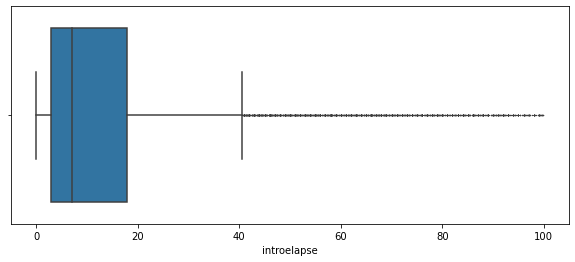

In [31]:
fig=plt.figure(figsize=(10,4))
sns.boxplot(data=file1, x='introelapse',fliersize=0.5)

100 секунд - вполне допустимое время, чтобы потратить на начальную страницу тестирования (в принципе, большие значения тоже допустимы, но считаем их выбросами из-за редкости таких случаев)

In [32]:
file1['surveyelapse'].describe()

count    3.977500e+04
mean     4.673672e+03
std      1.842179e+05
min      1.000000e+00
25%      1.450000e+02
50%      1.860000e+02
75%      2.480000e+02
max      2.082845e+07
Name: surveyelapse, dtype: float64

In [106]:
file1['surveyelapse']=file1['surveyelapse'].apply(dec_time)

<AxesSubplot:xlabel='surveyelapse'>

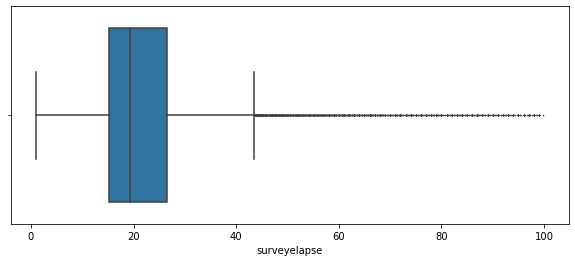

In [35]:
fig=plt.figure(figsize=(10,4))
sns.boxplot(data=file1, x='surveyelapse',fliersize=0.5)

Ситуация, аналогичная introelapse

In [36]:
q_i=['Q'+str(i)+'I' for i in range(1,43)]

In [40]:
find_err(file1[q_i], range(1,43))

[]

В признаках Q_i_I нет ошибочных значений

In [41]:
aa=[]
for i in range(file1.shape[0]):
    a=len(file1.iloc[i][q_i].unique())
    if a!=42: aa.append(a)
aa

[]

Нет повторов номеров

#### Тест TIPI

Набор ответов на тест TIPI - 10 утверждений, предлагается оценить, насколько учатник согласен с каждым из них, по шкале от 1 - абсолютно не согласен, 7 - абсолютно согласен


In [107]:
bad_ans=find_err(file1[['TIPI'+str(i) for i in range(1,11)]], range(1,8))

In [43]:
[file1.loc[bad_ans,'TIPI'+str(i) ].unique()for i in range(1,11)]

[array([0, 6, 5, 1, 2, 3, 4, 7], dtype=int64),
 array([0, 3, 1, 7, 6, 4, 2, 5], dtype=int64),
 array([0, 7, 6, 2, 5, 3, 4, 1], dtype=int64),
 array([0, 7, 6, 1, 2, 5, 4, 3], dtype=int64),
 array([0, 1, 6, 2, 5, 4, 7, 3], dtype=int64),
 array([0, 7, 6, 1, 4, 5, 3, 2], dtype=int64),
 array([0, 5, 1, 7, 6, 4, 2, 3], dtype=int64),
 array([0, 5, 1, 2, 6, 4, 7, 3], dtype=int64),
 array([0, 3, 7, 1, 4, 5, 2, 6], dtype=int64),
 array([0, 7, 6, 5, 1, 4, 2, 3], dtype=int64)]

In [108]:
ind_to_delete=[]
for j in list(set(bad_ans)):
    if file1[['TIPI'+str(i) for i in range(1,11)]].iloc[j].value_counts(normalize=True)[0]>=0.4:
        ind_to_delete.append(j)
file1=file1.drop(ind_to_delete)
#удалили записи, где большая часть информации потеряна

In [109]:
for x in ind_to_delete: bad_ans.remove(x)

In [110]:
#в оставшихся случаях заменим нулевые значения медианными по каждому участнику
for col in ['TIPI'+str(i) for i in range(1,11)]:
    mask=(file1[col]==0)
    file1.loc[mask, col]=file1.loc[mask, ['TIPI'+str(i) for i in range(1,11)]].median(axis=1)
file1.loc[:,['TIPI'+str(i) for i in range(1,11)]]=file1.loc[:,['TIPI'+str(i) for i in range(1,11)]].astype('int')

#### Тест VCL

16 вопросов, варианты ответа: 1 - значение слова знакомо, 0 - иначе

In [111]:
find_err(file1[['VCL'+str(_) for _ in range(1,17)]], [0,1])

[]

Нет ошибок

#### Личная информация

***education*** - 1=основное общее, 2=среднее общее, 3=бакалариат, 4=магистр	 

***urban (где провёл детство)***	- 1=деревня, 2=пригород, 3=город

***gender*** - 1=мужчина, 2=женщина, 3=другое

***engnat*** - 1=английский - родной язык, 2=иначе

***age***					

***hand***	- 1=правша, 2=левша, 3=амбидекстр

***religion***	- 1=агностик, 2=атеист, 3=буддист, 4=католик, 5=мормон, 6=протестант, 7=другие виды христианства, 8=хинди, 9=иудаизм, 10=мусульманство, 11=сикхи, 12=другое	

***race*** 10=азиат, 20=араб, 30=афроамериканец, 40=коренное население Австралии, 50=коренное население Америки, 60=европейцы, 70=другое	

***voted***				1=Yes, 2=No

***married***				1=Never married, 2=Currently married, 3=Previously married

***familysize***	(количество детей у матери)		

***major***				

**Технические данные**

***country***				

***screensize***			1=device with small screen (phone, etc), 2=device with big screen (laptop, desktop, etc)

***uniquenetworklocation***		1=only one survey from user's specific network in dataset, 2=multiple surveys submitted from the network of this user  (2 does not necessarily imply duplicate records for an individual, as it could be different students at a single school or different memebers of the same household; and even if 1 there still could be duplicate records from a single individual e.g. if they took it once on their wifi and once on their phone)

***source***			1=from the front page of the site hosting the survey, 2=from google, 0=other or unknown

In [112]:
file1['education'].unique()

array([2, 1, 3, 4, 0], dtype=int64)

In [113]:
file1['education']=file1['education'].replace(0,1)

In [114]:
mask=((file1['age']>150)|(file1['age']<=0))
file1.loc[mask,'age']

5340      223
10231    1996
30027    1993
33730    1991
Name: age, dtype: int64

In [115]:
file1.loc[5340, 'age']=23#видимо ошибка ввода, должно быть 22 или 23
mask=((file1['age']>150)&(file1['age']!=223))
#3 человека видимо написали свои года рождения

In [116]:
file1.loc[mask,'age']=2023-file1.loc[mask,'age']

In [117]:
file1['age'].describe()

count    39272.000000
mean        23.420350
std          8.617472
min         13.000000
25%         18.000000
50%         21.000000
75%         25.000000
max        117.000000
Name: age, dtype: float64

In [118]:
file1.religion.unique()

array([12,  7,  4, 10,  2,  6,  1,  8,  3,  0,  5, 11,  9], dtype=int64)

In [119]:
mask=(file1['religion']==0)
file1.loc[mask,'religion']=12     

In [120]:
[file1[col].value_counts(normalize=True) for col in ['urban', 'gender','hand', 'married']]

[3    0.447647
 2    0.334513
 1    0.208826
 0    0.009014
 Name: urban, dtype: float64,
 2    0.762630
 1    0.221863
 3    0.013878
 0    0.001630
 Name: gender, dtype: float64,
 1    0.873778
 2    0.104451
 3    0.017442
 0    0.004329
 Name: hand, dtype: float64,
 1    0.858907
 2    0.109391
 3    0.027348
 0    0.004354
 Name: married, dtype: float64]

In [121]:
for col in ['urban', 'gender','hand', 'married']:
    file1[col]=file1[col].replace(0, int(file1[col].median()))

In [122]:
[file1[col].value_counts(normalize=True) for col in ['engnat', 'voted','screensize','uniquenetworklocation']]

[2    0.636229
 1    0.362752
 0    0.001019
 Name: engnat, dtype: float64,
 2    0.713816
 1    0.278672
 0    0.007512
 Name: voted, dtype: float64,
 1    0.723569
 2    0.276431
 Name: screensize, dtype: float64,
 1    0.800672
 2    0.199328
 Name: uniquenetworklocation, dtype: float64]

Для локации и размера экрана всё ок

In [123]:
for col in ['engnat', 'voted']:
    file1[col]=file1[col].replace(0, int(file1[col].median()))

In [124]:
file1[file1['familysize']>7]['familysize'].value_counts()

8      664
9      325
10     192
11     108
12      54
13      18
14       8
15       6
16       5
17       3
54       1
99       1
65       1
62       1
19       1
26       1
24       1
23       1
21       1
133      1
Name: familysize, dtype: int64

In [125]:
file1['familysize']=file1['familysize'].replace(list(file1[file1['familysize']>54]['familysize']),\
                                                int(file1['familysize'].median()))

In [126]:
file1.race.value_counts()

10    22733
60    10612
70     4763
30      597
20      325
50      220
40       22
Name: race, dtype: int64

In [127]:
file1.source.value_counts()

0    14312
1    13977
2    10983
Name: source, dtype: int64

### Анализ ответов на тесты

In [128]:
columns_names=file1.columns
scale_q_names=list(columns_names[:126])+['introelapse', 'testelapse', 'surveyelapse']
scale_q_data=file1[scale_q_names]

In [129]:
tech_names=['country', 'source','screensize', 'uniquenetworklocation']
data_tech=file1[tech_names]

scale_t_names=['TIPI'+str(i) for i in range(1,11)]
scale_t_data=file1[scale_t_names]

scale_v_names=['VCL'+str(i) for i in range(1,17)]
scale_v_data=file1[scale_v_names]

personal_info_names=list(columns_names[157:162])+list(columns_names[164:171])
personal_info=file1[personal_info_names]

In [130]:
q_a=['Q'+str(i)+'A' for i in range(1,43)]
q_depr=[3,5,10,13,16,17,21]
q_depr+=[21+i for i in q_depr]
q_anx=[2,4,7,9, 15,19,20]
q_anx+=[21+i for i in q_anx]
q_str=[1,6,8,11,12,14,18]
q_str+=[21+i for i in q_str]
q_depr=['Q'+str(i)+'A' for i in q_depr]
q_anx=['Q'+str(i)+'A' for i in q_anx]
q_str=['Q'+str(i)+'A' for i in q_str]

In [131]:
res=scale_q_data[q_depr].sum(axis=1)
res.name='res_depr'
scale_q_data=pd.concat([scale_q_data, res], axis=1)

In [132]:
res=scale_q_data[q_anx].sum(axis=1)
res.name='res_anx'
scale_q_data=pd.concat([scale_q_data, res], axis=1)

res=scale_q_data[q_str].sum(axis=1)
res.name='res_str'
scale_q_data=pd.concat([scale_q_data, res], axis=1)

In [74]:
scale_q_data.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q41E,Q42A,Q42I,Q42E,introelapse,testelapse,surveyelapse,res_depr,res_anx,res_str
0,4,28,3.890,4,25,2.122,2,16,1.944,4,...,1.574,4,15,2.969,19.00,157.622,16.6,41,48,54
1,4,2,8.118,1,36,2.890,2,35,4.777,3,...,1.334,2,29,5.562,1.00,177.171,18.6,38,31,41
2,3,7,5.784,1,33,4.373,4,41,3.242,1,...,2.203,4,31,5.768,5.00,270.194,12.2,53,26,31
3,2,23,5.081,3,11,6.837,2,37,5.521,1,...,3.643,2,36,3.698,3.00,253.531,33.6,30,31,30
4,2,36,3.215,2,13,7.731,3,5,4.156,4,...,1.950,3,6,6.265,17.66,163.402,15.7,46,54,43


In [133]:
def levels(x, arr):
    for el in arr:
        if x<=el:
            return arr.index(el)
    return 'error'

In [134]:
res2=scale_q_data['res_depr'].apply(levels, arr=list(scale_q_data['res_depr'].describe()[-4:]))
res2.name='depr_level'

In [135]:
scale_q_data=pd.concat([scale_q_data,res2], axis=1)
scale_q_data.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q42A,Q42I,Q42E,introelapse,testelapse,surveyelapse,res_depr,res_anx,res_str,depr_level
0,4,28,3.890,4,25,2.122,2,16,1.944,4,...,4,15,2.969,19.00,157.622,16.6,41,48,54,2
1,4,2,8.118,1,36,2.890,2,35,4.777,3,...,2,29,5.562,1.00,177.171,18.6,38,31,41,2
2,3,7,5.784,1,33,4.373,4,41,3.242,1,...,4,31,5.768,5.00,270.194,12.2,53,26,31,3
3,2,23,5.081,3,11,6.837,2,37,5.521,1,...,2,36,3.698,3.00,253.531,33.6,30,31,30,1
4,2,36,3.215,2,13,7.731,3,5,4.156,4,...,3,6,6.265,17.66,163.402,15.7,46,54,43,2


In [136]:
res2=scale_q_data['res_anx'].apply(levels, arr=list(scale_q_data['res_anx'].describe()[-4:]))
res2.name='anx_level'
scale_q_data=pd.concat([scale_q_data,res2], axis=1)

In [137]:
res2=scale_q_data['res_str'].apply(levels, arr=list(scale_q_data['res_str'].describe()[-4:]))
res2.name='str_level'
scale_q_data=pd.concat([scale_q_data,res2], axis=1)
scale_q_data.head()

,Q1A,Q1I,Q1E,Q2A,Q2I,Q2E,Q3A,Q3I,Q3E,Q4A,...,Q42E,introelapse,testelapse,surveyelapse,res_depr,res_anx,res_str,depr_level,anx_level,str_level
0,4,28,3.890,4,25,2.122,2,16,1.944,4,...,2.969,19.00,157.622,16.6,41,48,54,2,3,3
1,4,2,8.118,1,36,2.890,2,35,4.777,3,...,5.562,1.00,177.171,18.6,38,31,41,2,2,2
2,3,7,5.784,1,33,4.373,4,41,3.242,1,...,5.768,5.00,270.194,12.2,53,26,31,3,1,1
3,2,23,5.081,3,11,6.837,2,37,5.521,1,...,3.698,3.00,253.531,33.6,30,31,30,1,2,1
4,2,36,3.215,2,13,7.731,3,5,4.156,4,...,6.265,17.66,163.402,15.7,46,54,43,2,3,2


Как соотносятся между собой результаты этого теста

Какие признаки наиболее характерны для людей с выраженной депрессией?

Какие признаки наименее характерны для людей с выраженной депрессией?

Аналогичные вопросы про стресс и тревогу

Есть ли зависимость между очерёдностью вопросов и скоростью ответа/результатом

Есть ли зависимость между скоростью ответа и результатом

Найдём вопрос, на который тратят больше/меньше всех времени, посмотрим график времени от его номера очерёдности

In [138]:
np.argmax(scale_q_data[qe_names].median()) #вопрос 25 из блока на тревожность

24

<AxesSubplot:title={'center':'Q25E'}, xlabel='Q25I'>

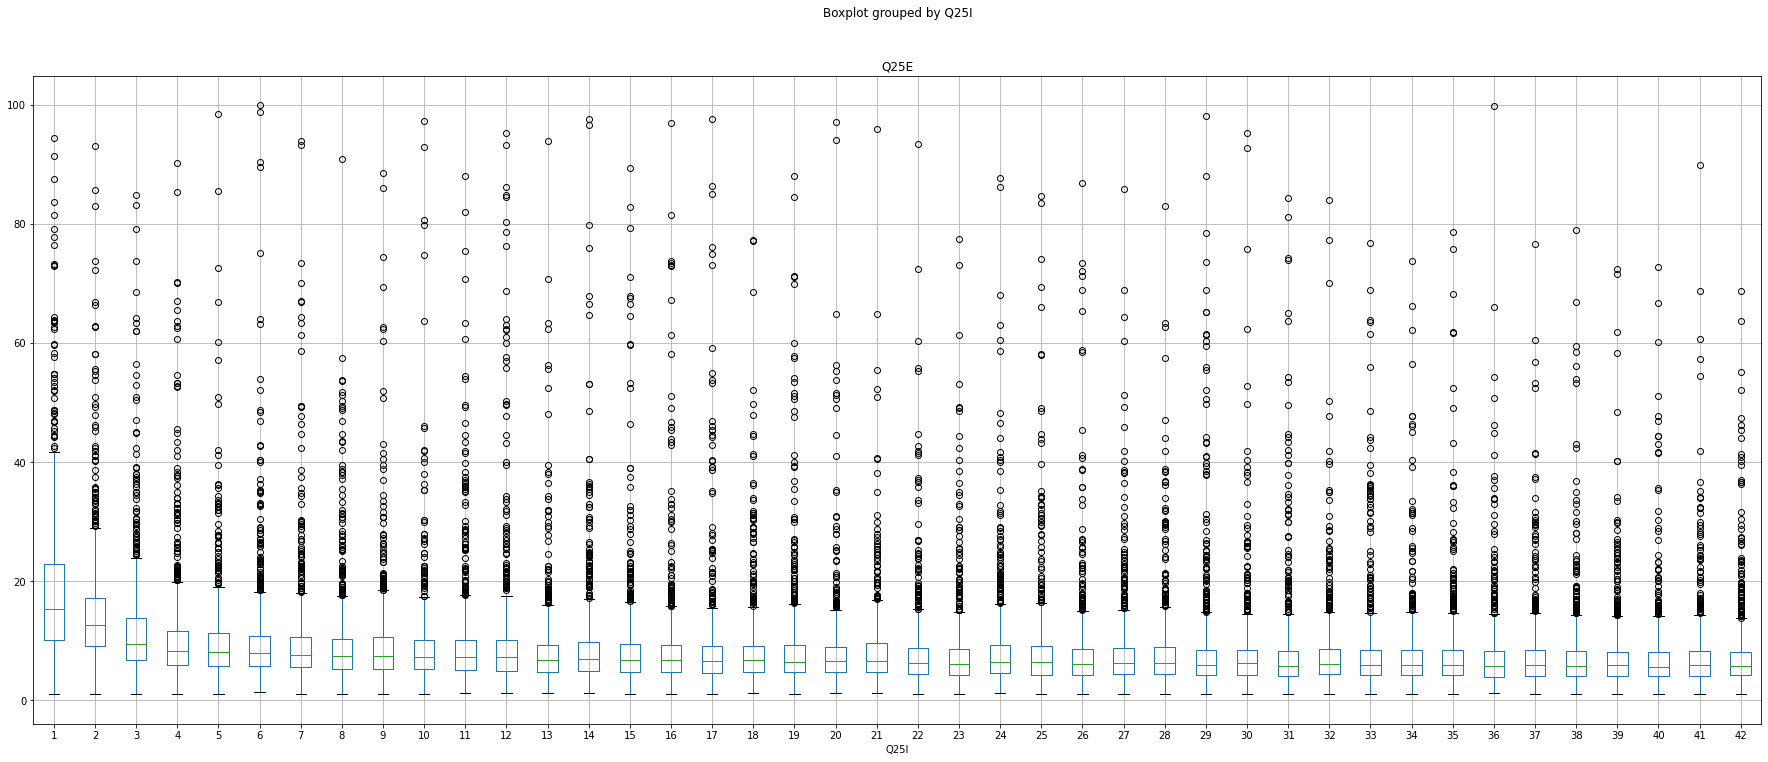

In [143]:
scale_q_data.boxplot(column='Q25E', by='Q25I',figsize=(30,12))

In [144]:
np.argmin(scale_q_data[qe_names].median()) #36 вопрос тоже из блока про тревожность

35

<AxesSubplot:title={'center':'Q36E'}, xlabel='Q36I'>

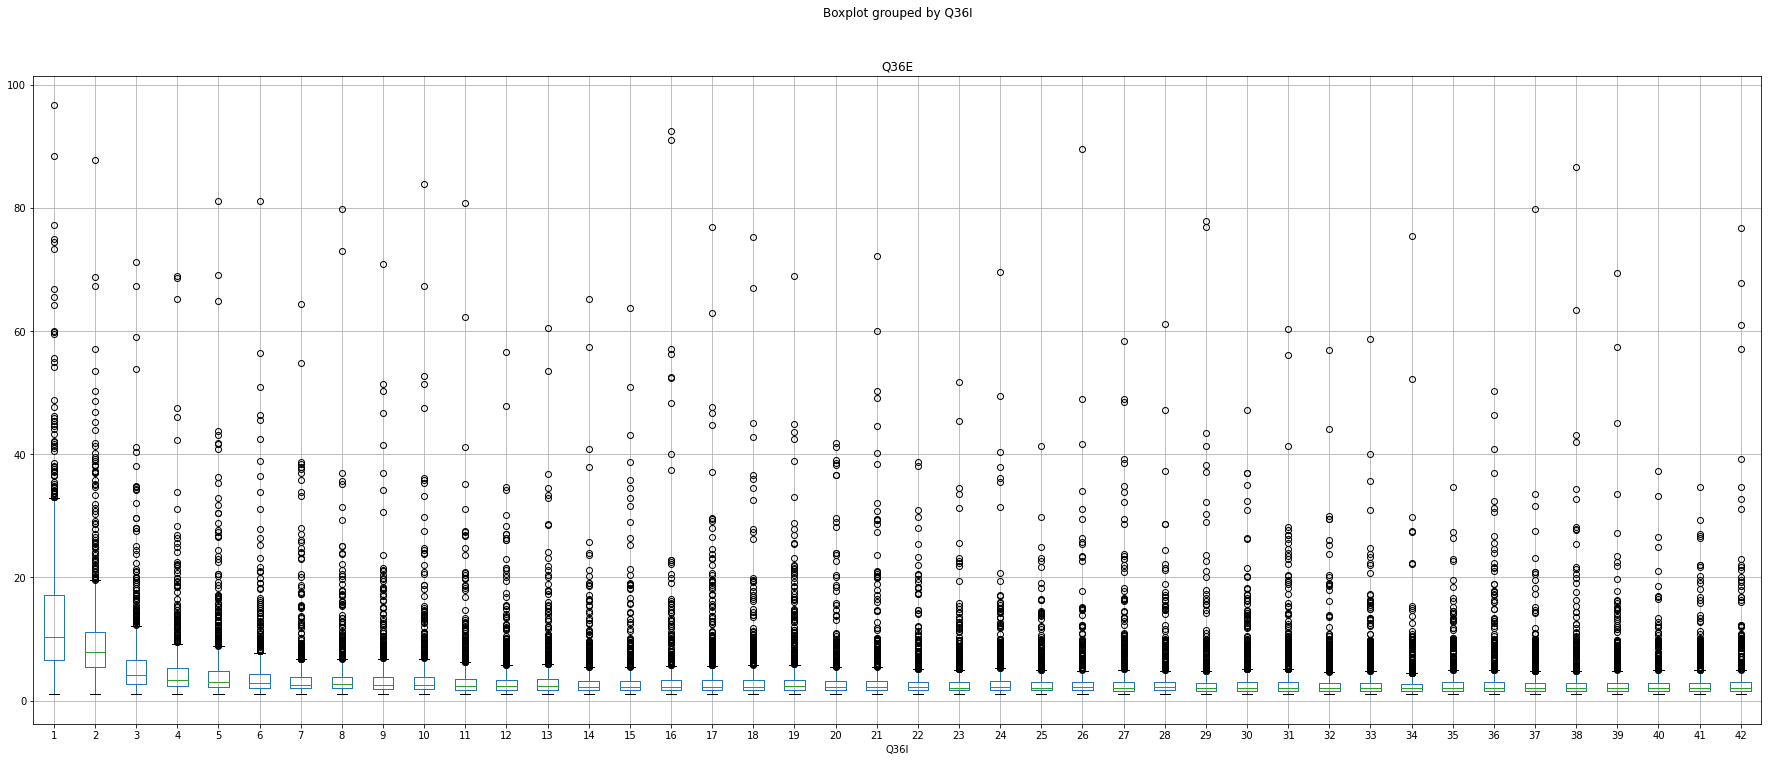

In [145]:
scale_q_data.boxplot(column='Q36E', by='Q36I',figsize=(30,12))

Q25 I was aware of the action of my heart in the absence of physical exertion (eg, sense of heart rate increase, heart missing a beat)

Q36 I felt terrified

скорость ответа в зависимости от выбора ответа?

In [146]:
pd.pivot_table(scale_q_data, index=['depr_level', 'str_level'], values=['Q25E', 'Q36E'], aggfunc='median')

Q25E    Q36E
depr_level str_level                
0          0          6.8220  2.1680
           1          7.0590  2.5100
           2          6.7190  2.3970
           3          5.8050  2.4060
1          0          6.9465  2.3970
           1          7.2560  2.5325
           2          6.9665  2.5205
           3          6.4630  2.3260
2          0          6.5715  2.4715
           1          6.8630  2.4940
           2          6.8255  2.3775
           3          6.6475  2.2335
3          0          6.3440  2.4390
           1          6.6990  2.4670
           2          6.7350  2.2980
           3          6.0500  1.9740

Медленнее выбирают 2 вариант ответа, возможно из-за сложности оценки невыраженного состояния (возможно также что такие результаты завышены или занижены в отдельных случаях, так как кто-то боится неправильно себя оценить и приуменьшает свои проблемы, а кто-то склонен к мнительности)

In [147]:
scale_q_data['Q36A'].value_counts(normalize=True)

1    0.315517
2    0.302073
4    0.199862
3    0.182547
Name: Q36A, dtype: float64

In [148]:
scale_q_data['Q25A'].value_counts(normalize=True)

1    0.341363
2    0.299552
3    0.192860
4    0.166225
Name: Q25A, dtype: float64

In [ ]:
scale_q_data.groupby('')

In [81]:
scale_q_data.groupby('depr_level')[['anx_level','str_level']].describe()

anx_level                                              str_level  \
               count      mean       std  min  25%  50%  75%  max     count   
depr_level                                                                    
0            10553.0  0.462523  0.732350  0.0  0.0  0.0  1.0  3.0   10553.0   
1             9801.0  1.247220  0.948575  0.0  1.0  1.0  2.0  3.0    9801.0   
2             9941.0  1.840157  0.988007  0.0  1.0  2.0  3.0  3.0    9941.0   
3             8977.0  2.364821  0.887388  0.0  2.0  3.0  3.0  3.0    8977.0   

                                                         
                mean       std  min  25%  50%  75%  max  
depr_level                                               
0           0.417038  0.698586  0.0  0.0  0.0  1.0  3.0  
1           1.232833  0.892638  0.0  1.0  1.0  2.0  3.0  
2           1.881400  0.902443  0.0  1.0  2.0  3.0  3.0  
3           2.483458  0.782766  0.0  2.0  3.0  3.0  3.0

In [83]:
scale_q_data[['depr_level','anx_level','str_level']].corr()

,depr_level,anx_level,str_level
depr_level,1.000000,0.619237,0.680725
anx_level,0.619237,1.000000,0.747659
str_level,0.680725,0.747659,1.000000


Видно, что наиболее существенная корреляция между уровнями стресса и тревоги. Между депрессией и тревожностью тоже есть корреляция, пусть и более слабая

<AxesSubplot:>

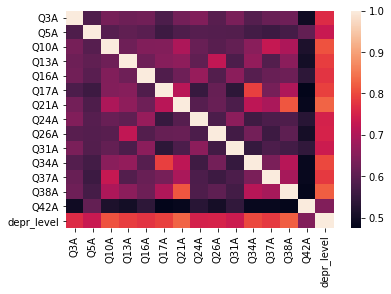

In [83]:
sns.heatmap(scale_q_data[q_depr+['depr_level']].corr())

In [85]:
scale_q_data[q_depr+['depr_level']].corr()['depr_level']

Q3A           0.764733
Q5A           0.735018
Q10A          0.811211
Q13A          0.788118
Q16A          0.778457
Q17A          0.791406
Q21A          0.827988
Q24A          0.750481
Q26A          0.752851
Q31A          0.739372
Q34A          0.800785
Q37A          0.784188
Q38A          0.822317
Q42A          0.646780
depr_level    1.000000
Name: depr_level, dtype: float64

Наиболее взаимосвязаны вопросы 17 и 34, 21 и 38, при этом связь вопроса 42 со всеми остальными - наименьшая.
Также наибольшая корреляция заметна между итоговым результатом и вопросами 10, 21 и 38. Ответ на 42 вопрос возможно оказывает наименьшее влияние на результат теста.

<AxesSubplot:xlabel='Q21A', ylabel='count'>

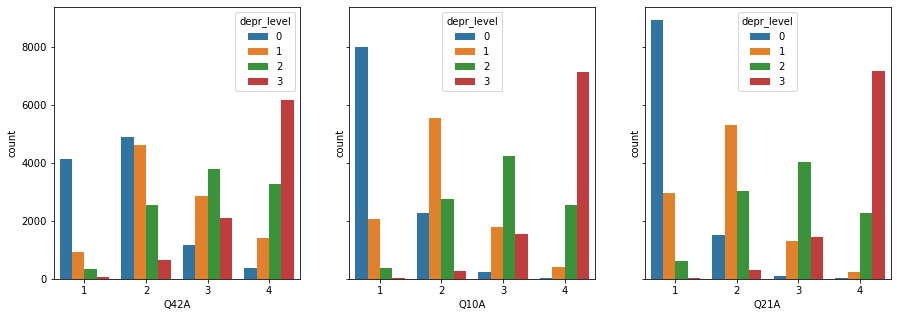

In [86]:
fig,ax=plt.subplots(1,3, figsize=(15,5), sharey=True)
sns.countplot(x=scale_q_data['Q42A'], hue=scale_q_data['depr_level'], ax=ax[0])
sns.countplot(x=scale_q_data['Q10A'], hue=scale_q_data['depr_level'], ax=ax[1])
sns.countplot(x=scale_q_data['Q21A'], hue=scale_q_data['depr_level'], ax=ax[2])

Вопрос 42 нельзя убрать из рассмотрения, так как в целом прослеживается связь между ответом на него и выраженностью депрессии, но стоит обратить внимание на то, что отсутствие этого симптома встречается при депрессии разной степени тяжести чаще, чем в случае с другими вопросами. 

Вопрос 42 касается способности проявлять инициативу, что зависит от многих факторов и не обязательно свидетельствует о психологических проблемах

<AxesSubplot:xlabel='str_level', ylabel='count'>

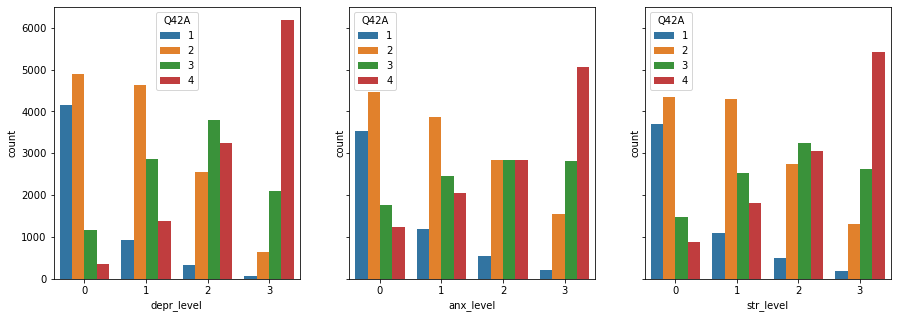

In [89]:
fig,ax=plt.subplots(1,3, figsize=(15,5), sharey=True)
sns.countplot(x=scale_q_data['depr_level'], hue=scale_q_data['Q42A'], ax=ax[0])
sns.countplot(x=scale_q_data['anx_level'], hue=scale_q_data['Q42A'], ax=ax[1])
sns.countplot(x=scale_q_data['str_level'], hue=scale_q_data['Q42A'], ax=ax[2])

Среди людей с тяжёлым течением депрессии большинство отмечает у себя серьёзные проблемы с инициативностью, для людей с высокими уровнями стресса или тревожности тоже характерна эта проблема. Однако эта проблема встречается и среди людей с низким уровнем тревоги и стресса.

In [190]:
names=[]
for name in q_anx:
    names.append(scale_q_data[scale_q_data.anx_level==0][name].value_counts(normalize=True,sort=True)[0])       
np.array(q_anx)[np.argsort(names)[-3:]], np.array(names)[np.argsort(names)[-3:]]

(array(['Q4A', 'Q7A', 'Q23A'], dtype='<U4'),
 array([0.85576573, 0.87577301, 0.93606766]))

In [191]:
names=[]
for name in q_anx:
    names.append(scale_q_data[scale_q_data.anx_level==0][name].value_counts(normalize=True,sort=True)[3])       
np.array(q_anx)[np.argsort(names)[-3:]], np.array(names)[np.argsort(names)[-3:]]

(array(['Q40A', 'Q9A', 'Q2A'], dtype='<U4'),
 array([0.01827937, 0.0191888 , 0.02446344]))

In [192]:
names=[]
for name in q_anx:
    names.append(scale_q_data[scale_q_data.anx_level==3][name].value_counts(normalize=True,sort=True)[0])       
np.array(q_anx)[np.argsort(names)[-3:]], np.array(names)[np.argsort(names)[-3:]]

(array(['Q19A', 'Q15A', 'Q23A'], dtype='<U4'),
 array([0.11063874, 0.1110535 , 0.22666943]))

In [193]:
names=[]
for name in q_anx:
    names.append(scale_q_data[scale_q_data.anx_level==3][name].value_counts(normalize=True,sort=True)[3])       
np.array(q_anx)[np.argsort(names)[-3:]], np.array(names)[np.argsort(names)[-3:]]

(array(['Q20A', 'Q9A', 'Q40A'], dtype='<U4'),
 array([0.59695147, 0.68851099, 0.71443384]))

In [194]:
names=[]
for name in q_str:
    names.append(scale_q_data[scale_q_data.str_level==0][name].value_counts(normalize=True,sort=True)[0])       
np.array(q_str)[np.argsort(names)[-3:]], np.array(names)[np.argsort(names)[-3:]]

(array(['Q33A', 'Q12A', 'Q22A'], dtype='<U4'),
 array([0.59532253, 0.60318221, 0.6235982 ]))

In [195]:
names=[]
for name in q_str:
    names.append(scale_q_data[scale_q_data.str_level==0][name].value_counts(normalize=True,sort=True)[3])       
np.array(q_str)[np.argsort(names)[-3:]], np.array(names)[np.argsort(names)[-3:]]

(array(['Q18A', 'Q11A', 'Q14A'], dtype='<U4'),
 array([0.01533595, 0.01686955, 0.0335474 ]))

In [198]:
names=[]
for name in q_str:
    names.append(scale_q_data[scale_q_data.str_level==3][name].value_counts(normalize=True,sort=True)[0])       
np.array(q_str)[np.argsort(names)[:3]], np.array(names)[np.argsort(names)[:3]]

(array(['Q11A', 'Q29A', 'Q1A'], dtype='<U4'),
 array([0.00199224, 0.00450876, 0.00461361]))

In [197]:
names=[]
for name in q_str:
    names.append(scale_q_data[scale_q_data.str_level==3][name].value_counts(normalize=True,sort=True)[3])       
np.array(q_str)[np.argsort(names)[-3:]], np.array(names)[np.argsort(names)[-3:]]

(array(['Q27A', 'Q29A', 'Q11A'], dtype='<U4'),
 array([0.71469015, 0.73912132, 0.8298207 ]))

In [199]:
names=[]
for name in q_str:
    names.append(scale_q_data[scale_q_data.str_level==3][name].value_counts(normalize=True,sort=True)[3])       
np.array(q_str)[np.argsort(names)[:3]], np.array(names)[np.argsort(names)[:3]]

(array(['Q35A', 'Q22A', 'Q32A'], dtype='<U4'),
 array([0.4709028 , 0.53433994, 0.55981965]))

#### На какие вопросы чаще отвечали 4 (тяжёлое проявление депрессивного симптома)?

In [45]:
names4=[]
for name in ['Q'+str(i)+'A' for i in range(1,43)]:
    if scales_q_answers[name].value_counts(normalize=True,sort=False).idxmax()==4:
        names4.append(name)
names4
 

['Q11A', 'Q13A', 'Q17A', 'Q34A', 'Q40A']

На эти вопросы выбирали вариант ответа 4, чем другие варианты 

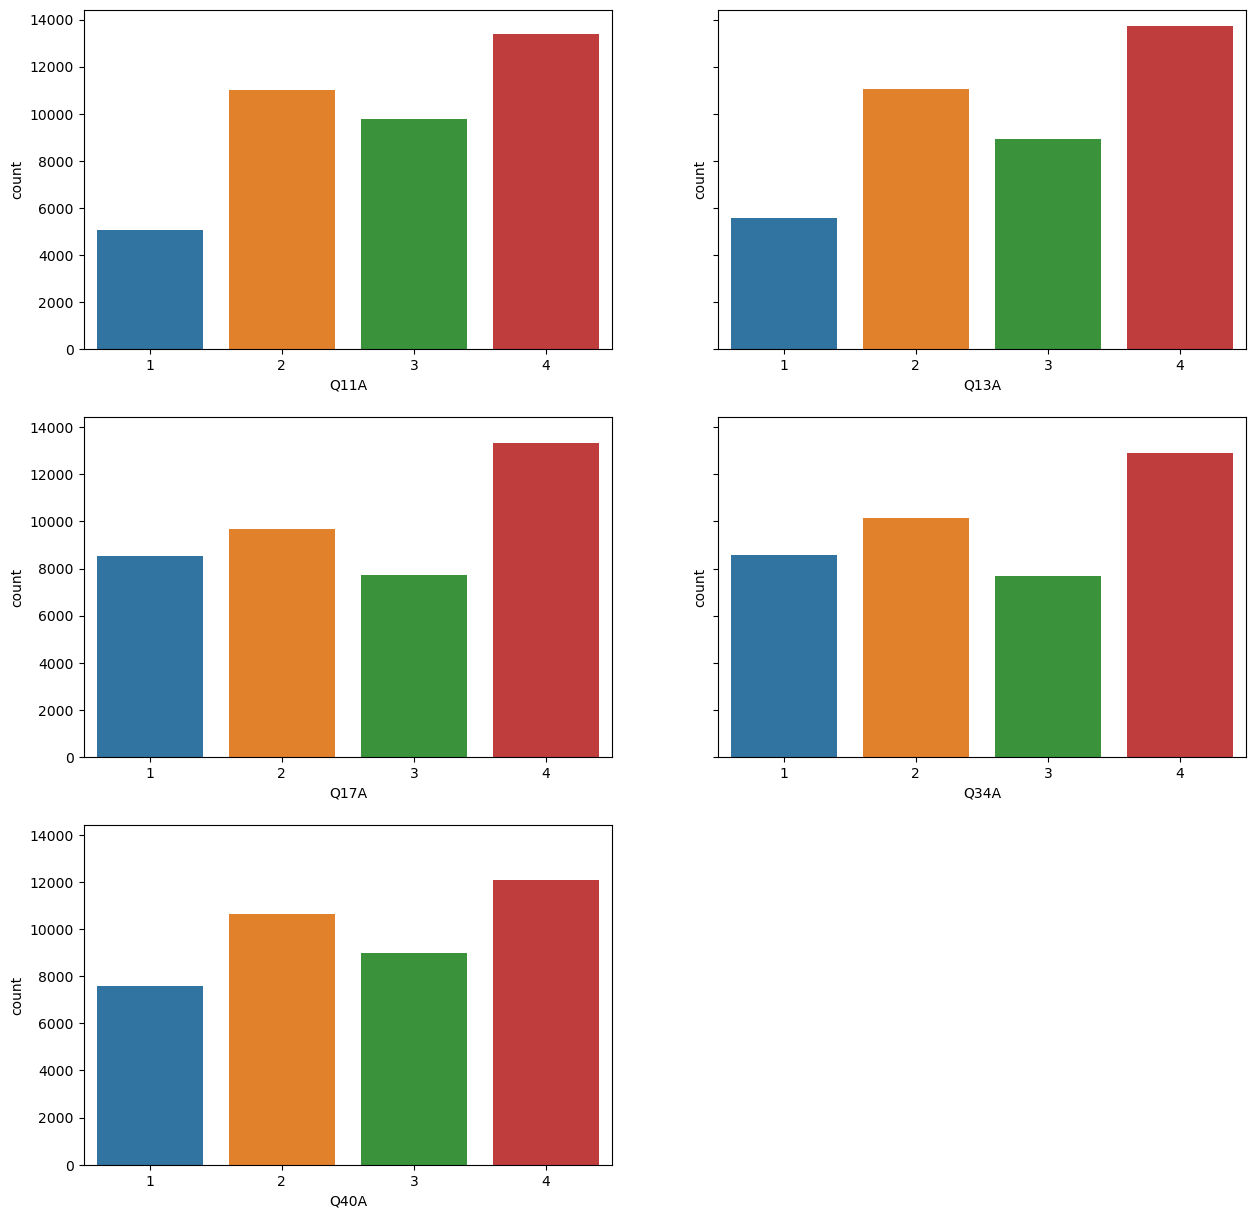

In [46]:
fig, ax=plt.subplots(3,2, figsize=(15,15), sharey=True)
i,j=0,0
for name in names4:
    sns.countplot(x=scales_q_answers[name], ax=ax[i,j])
    j+=1
    if j==2:
        j=0
        i+=1
fig.delaxes(ax[2,1])

В вопросах 11 и 13 видна существенная разница между количеством ответов 1 и 4, в остальных случаях разница не так велика (примерно в 1.5 раза). Возможно эти симптомы более распространены и у здоровых людей.

Q11	I found myself getting upset rather easily.

Q13	I felt sad and depressed.

Q17	I felt I wasn&#39;t worth much as a person.

Q34	I felt I was pretty worthless.

Q40	I was worried about situations in which I might panic and make a fool of myself.

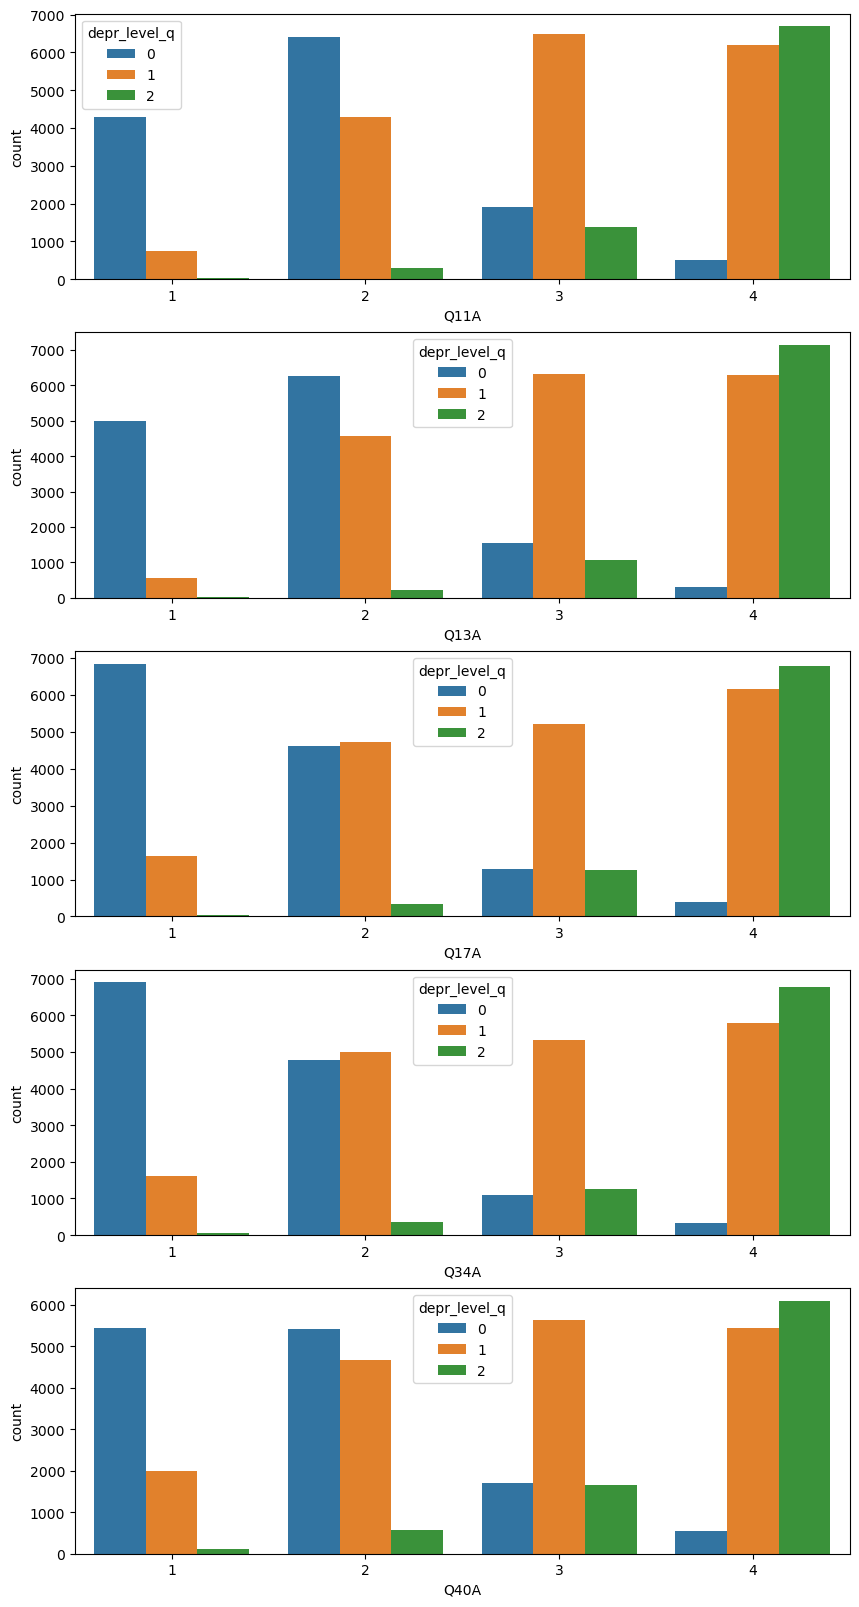

In [47]:
fig, ax=plt.subplots(5, figsize=(10,20))
i=0
for name in names4:
    sns.countplot(x=scales_q_answers[name], hue=scales_q_answers['depr_level_q'], ax=ax[i])
    i+=1

Видно, что вариант 4 обычно выбирают люди с целом более выраженными депрессивными симптомами

При этом люди с низким уровнем депрессивности с примерно одинаковой частотой отмечают у себя как и полное отсутствие симптомов 11, 13, 40, так и небольшое их присутствие.

In [50]:
scales_q_answers[(scales_q_answers['Q13A']==4) & (scales_q_answers['depr_level_q']==0)]\
[['Q'+str(i)+'A' for i in range(1,43)]+['result']]

,Q1A,Q2A,Q3A,Q4A,Q5A,Q6A,Q7A,Q8A,Q9A,Q10A,...,Q34A,Q35A,Q36A,Q37A,Q38A,Q39A,Q40A,Q41A,Q42A,result
166,1,1,2,1,2,3,1,2,3,2,...,1,1,1,3,2,3,3,1,3,84
457,1,1,3,1,2,1,1,1,1,4,...,3,2,2,4,4,1,1,1,2,74
783,1,1,2,1,1,1,2,1,3,2,...,3,2,1,3,4,2,4,1,3,79
837,3,1,3,1,3,2,1,1,1,3,...,2,1,1,4,3,2,2,1,4,83
970,1,1,2,2,4,2,1,1,1,3,...,4,1,1,4,3,1,1,1,3,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38497,3,1,2,1,1,2,1,1,4,1,...,1,3,2,2,1,4,3,1,4,84
38521,3,1,2,1,3,1,1,3,1,4,...,4,1,1,3,1,1,1,1,4,79
38827,1,1,1,1,2,2,1,3,2,2,...,3,3,1,3,2,1,3,1,2,82
39312,1,1,2,1,1,1,1,2,2,3,...,4,1,1,2,3,1,1,1,1,72


#### Какие симптомы реже всего у себя замечали участники?

In [51]:
names1=[]
for name in ['Q'+str(i)+'A' for i in range(1,43)]:
    if scales_q_answers[name].value_counts(normalize=True,sort=False).idxmax()==1:
        names1.append(name)
names1 

['Q2A',
 'Q4A',
 'Q7A',
 'Q15A',
 'Q19A',
 'Q20A',
 'Q21A',
 'Q23A',
 'Q25A',
 'Q28A',
 'Q36A',
 'Q37A',
 'Q38A',
 'Q41A']

На эти вопросы отвечали чаще 1, чем другие варианты

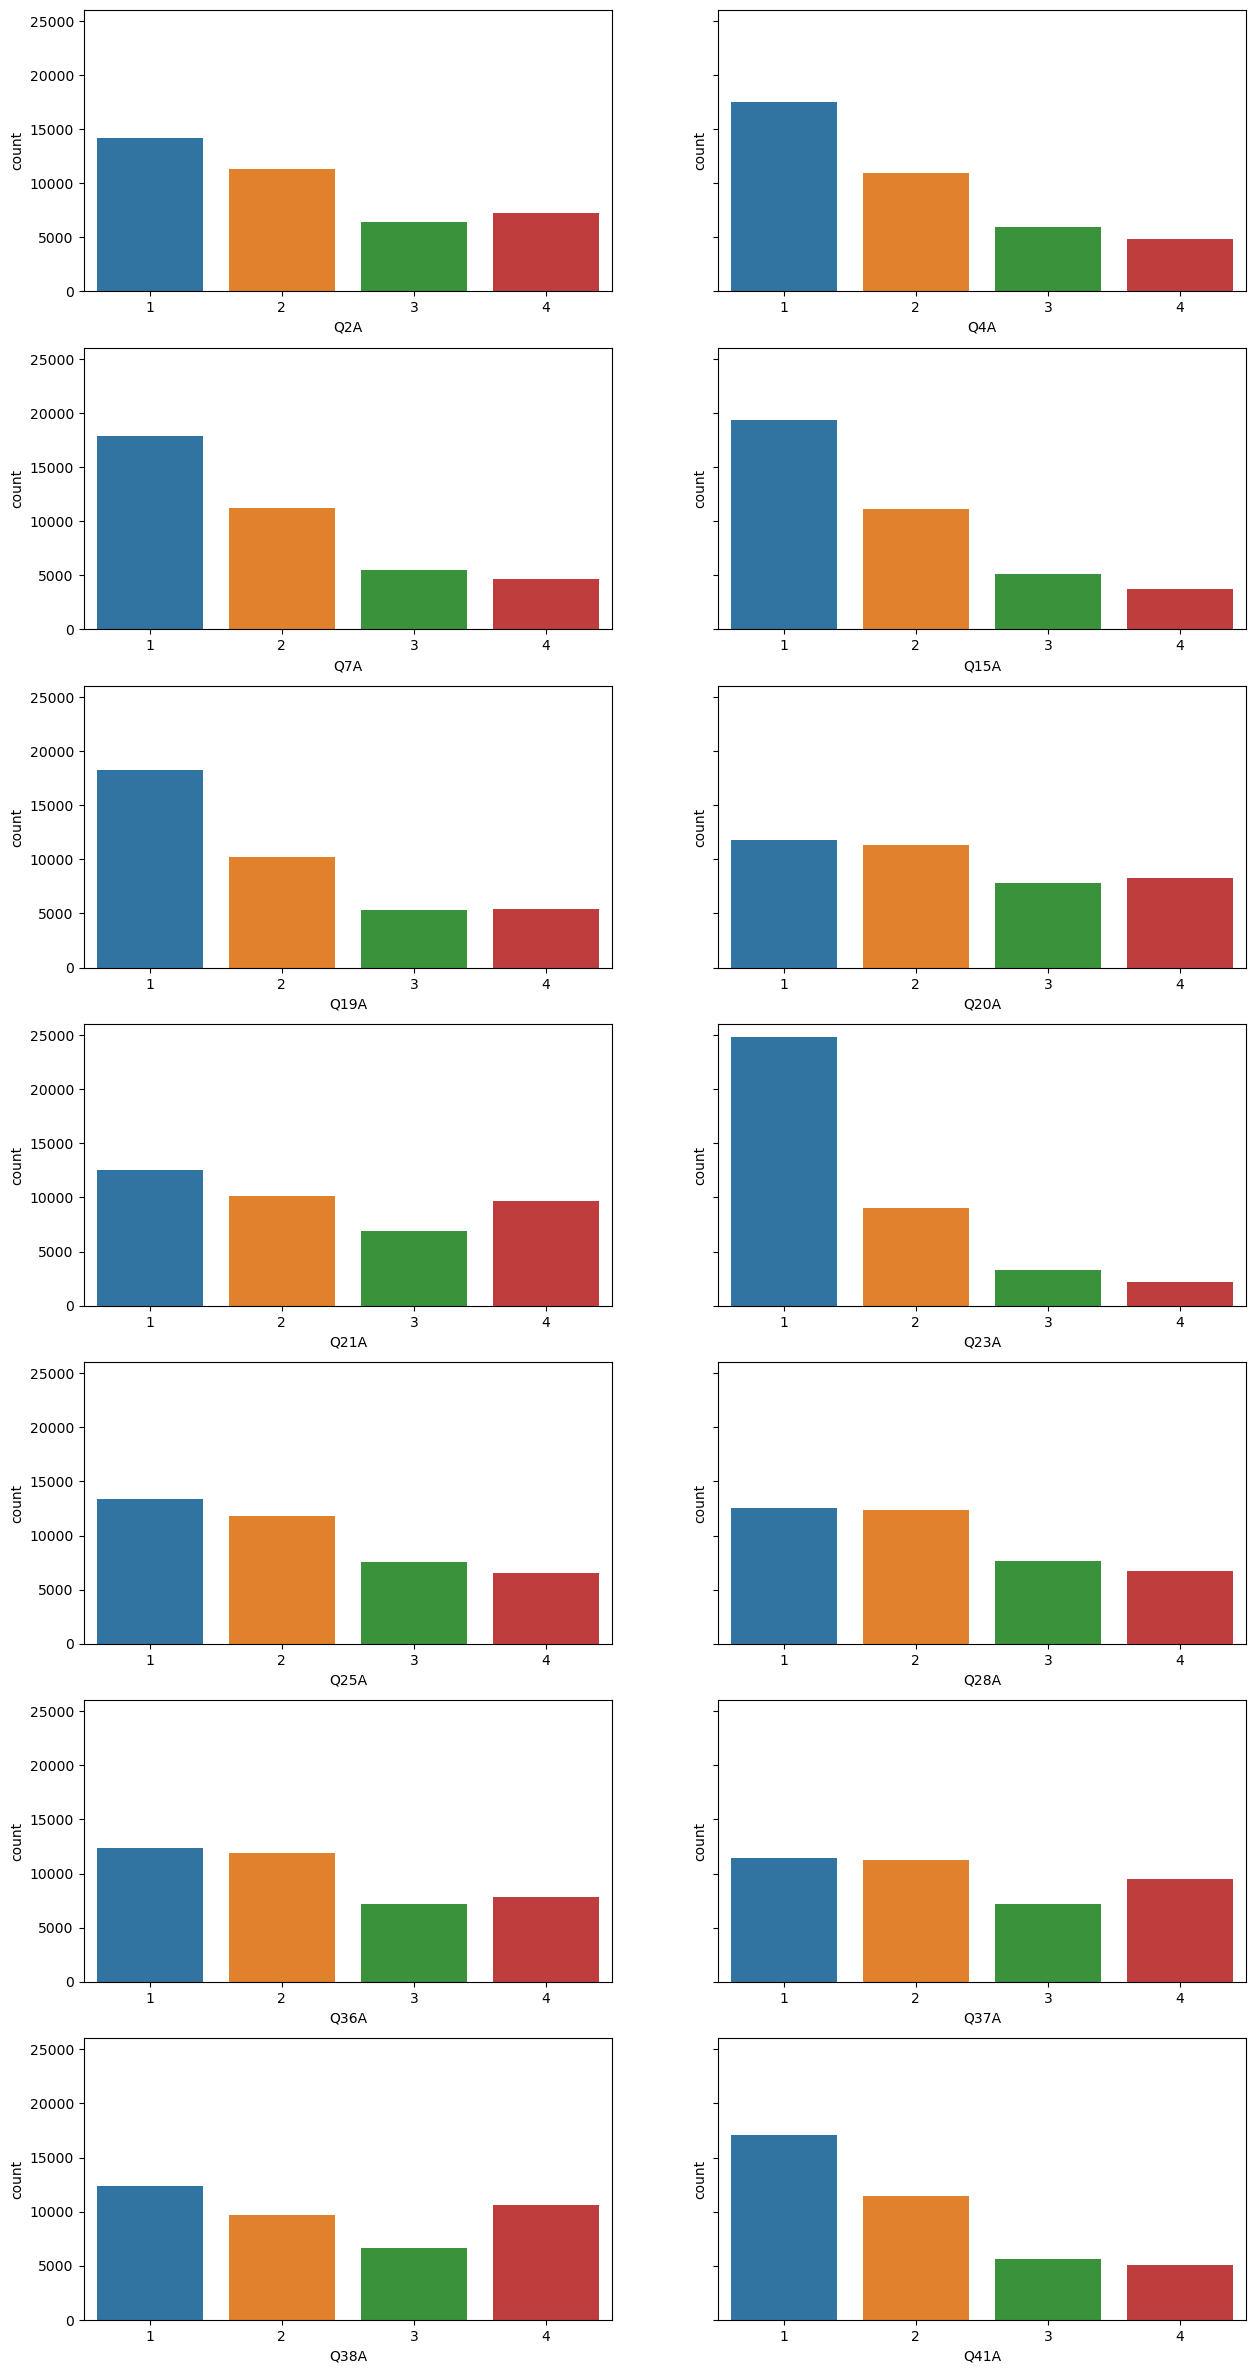

In [52]:
fig, ax=plt.subplots(7,2, figsize=(15,30), sharey=True)
i,j=0,0
for name in names1:
    sns.countplot(x=scales_q_answers[name], ax=ax[i,j])
    j+=1
    if j==2:
        j=0
        i+=1

На вопросы 15 и 23 реже всего отвечают "4", проверим, как ответы на эти вопросы соотносятся с проявлением депрессивных симптомов в целом

<Axes: xlabel='Q23A', ylabel='count'>

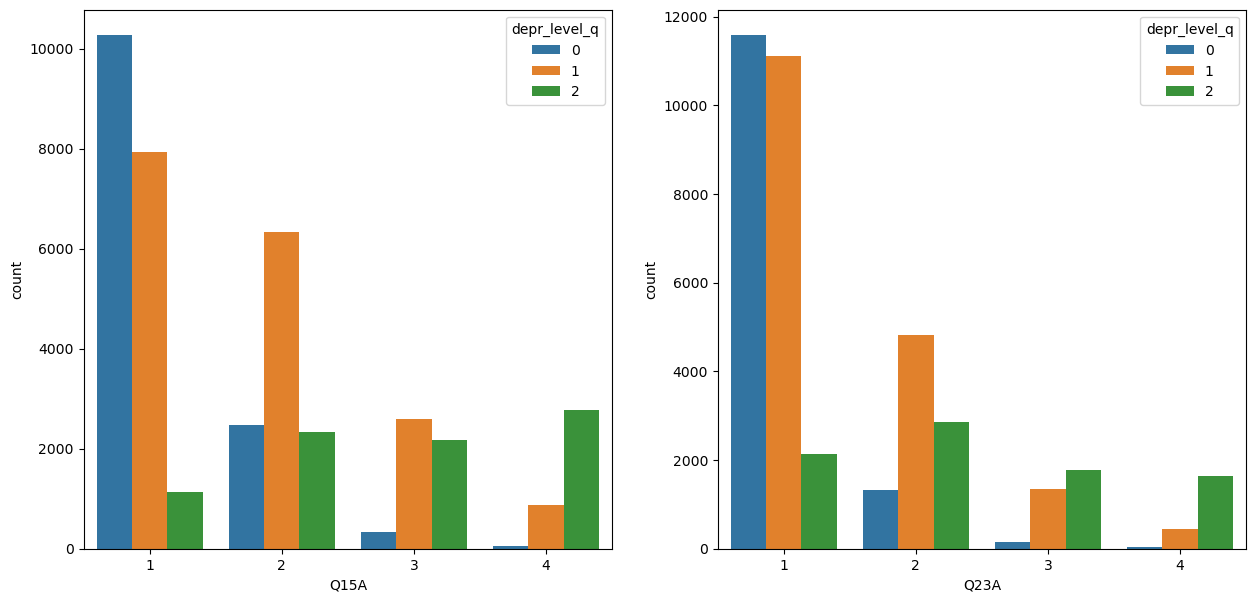

In [53]:
fig, ax=plt.subplots(1,2, figsize=(15,7))
sns.countplot(x=scales_q_answers['Q15A'], hue=scales_q_answers['depr_level_q'], ax=ax[0])
sns.countplot(x=scales_q_answers['Q23A'], hue=scales_q_answers['depr_level_q'], ax=ax[1])

Для людей с выраженными депрессивными симптомами вопросы 15 и 23 не являются определяющими

Q15	I had a feeling of faintness

Q23	I had difficulty in swallowing

Больше похоже на физические симптомы, которые могут возникнуть по разным причинам

Доли ответов на вопросы 20, 21, 36, 37, 38 имеют небольшой разброс. Рассмотрим их в зависимости от степени выраженности депрессивных симптомов

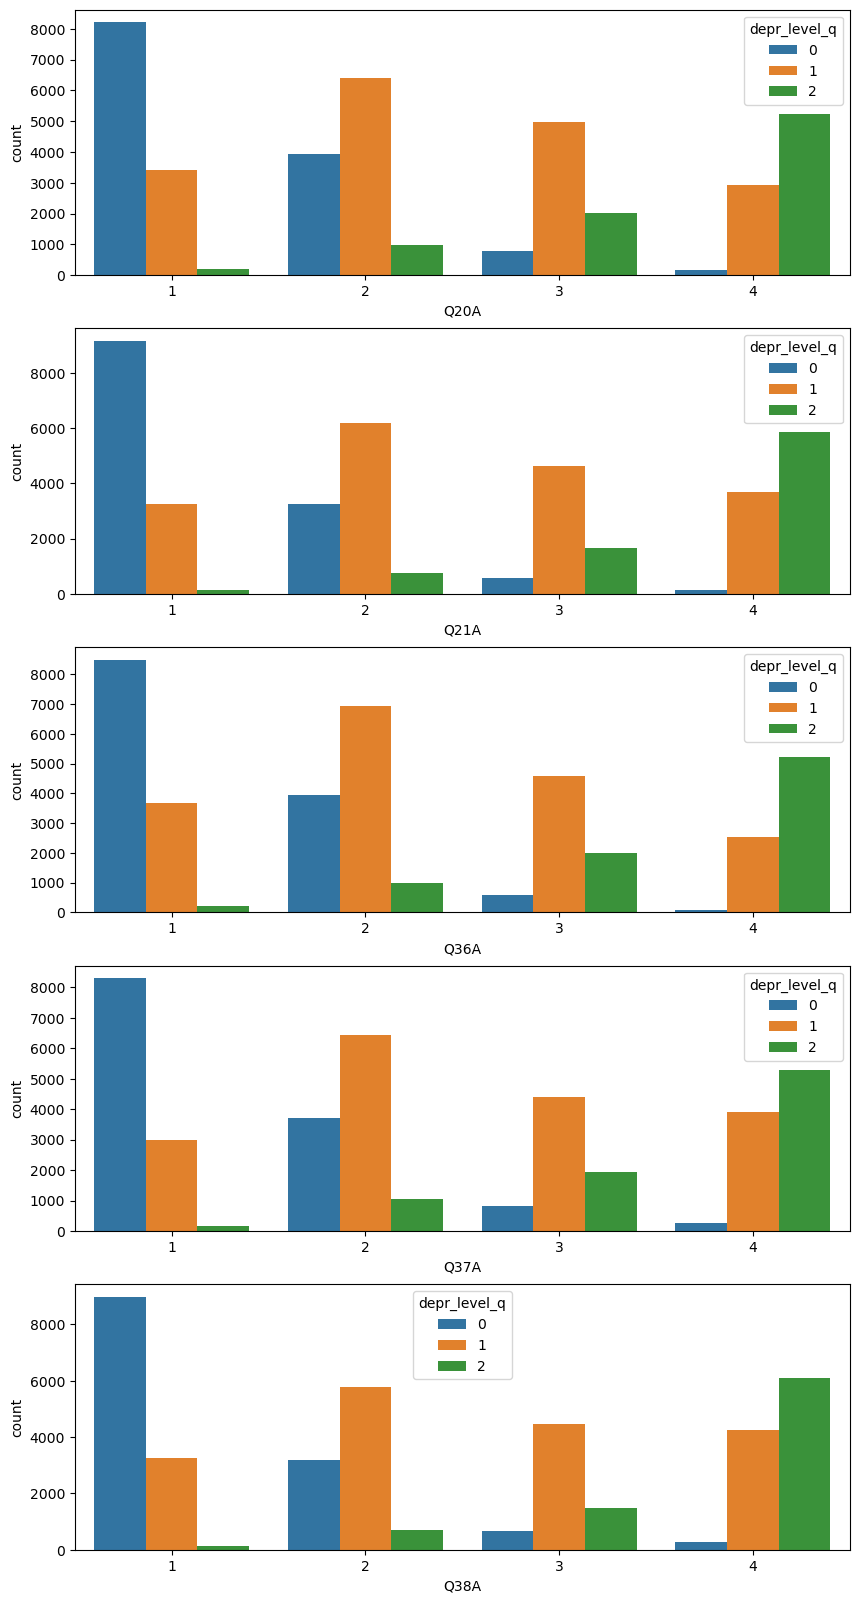

In [54]:
fig, ax=plt.subplots(5, figsize=(10,20))
i=0
for name in ['Q20A', 'Q21A', 'Q36A','Q37A','Q38A']:
    sns.countplot(x=scales_q_answers[name], hue=scales_q_answers['depr_level_q'], ax=ax[i])
    i+=1

Люди со средним проявлением депрессии (уровень 2) симптомы 21, 37, 38 встречаются примерно одинаково в разной степени интенсивности. Для людей с другими уровнями депрессивности прослеживается более чёткая связь между вариантом ответа и тяжестью депресси в целом.

Q21	I felt that life wasn't worthwhile

Q37	I could see nothing in the future to be hopeful about.

Q38	I felt that life was meaningless.

#### Какие признаки наиболее существенны/несущественны при выявлении депрессии?

<AxesSubplot:>

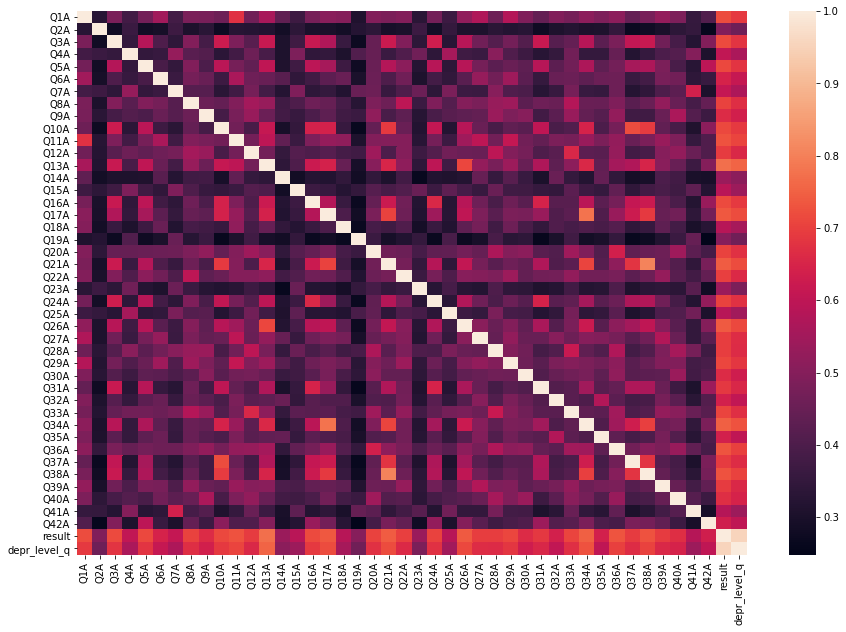

In [45]:
fig=plt.figure(figsize=(15,10))
sns.heatmap(scales_q_answers.corr())

In [55]:
a=scales_q_answers.corr().unstack()['result']

In [56]:
b=a[:-2].sort_values()
important_q=b[-10:].index#чем больше корр тем больше результат зависит от вопроса
list(important_q)

['Q10A', 'Q3A', 'Q11A', 'Q36A', 'Q38A', 'Q17A', 'Q26A', 'Q21A', 'Q34A', 'Q13A']

In [57]:
#corr->1 - лин зав
#corr->0 - лин незав

<Axes: >

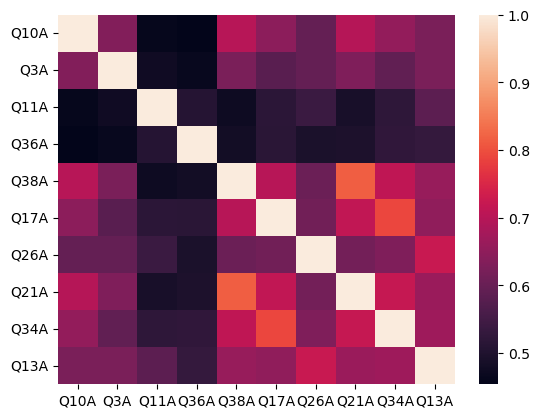

In [58]:
sns.heatmap(scales_q_answers[important_q].corr())

Есть существенная корреляция между вопросами 38-21 и 17-34

Q17	I felt I wasn't worth much as a person.  Q34	I felt I was pretty worthless

Q21	I felt that life wasn&#39;t worthwhile  Q38	I felt that life was meaningless

В целом, такой результат ожидаем, формулировки похожи

In [59]:
scales_q_answers[scales_q_answers['Q17A']==scales_q_answers['Q34A']][['Q17A', 'depr_level_q']].\
                                                                     value_counts(sort=False,normalize=True)

Q17A  depr_level_q
1     0               0.209781
      1               0.032823
      2               0.000781
2     0               0.108344
      1               0.101788
      2               0.004840
3     0               0.017251
      1               0.100617
      2               0.020920
4     0               0.005386
      1               0.161541
      2               0.235930
dtype: float64

In [60]:
scales_q_answers[scales_q_answers['Q17A']!=scales_q_answers['Q34A']][['Q17A', 'Q34A','depr_level_q']].\
                                                                     value_counts(sort=False,normalize=True)

Q17A  Q34A  depr_level_q
1     2     0               0.093480
            1               0.040000
            2               0.000733
      3     0               0.010696
            1               0.012527
            2               0.000513
      4     0               0.003077
            1               0.006667
            2               0.000733
2     1     0               0.098901
            1               0.037582
            2               0.000806
      3     0               0.029963
            1               0.087985
            2               0.008132
      4     0               0.004908
            1               0.029817
            2               0.007179
3     1     0               0.010110
            1               0.011355
            2               0.000366
      2     0               0.044615
            1               0.097143
            2               0.007692
      4     0               0.006813
            1               0.084103
            2

In [61]:
#уберём вопросы, между которыми есть существенная корреляция
important_q=list(important_q)
important_q.remove('Q38A')
important_q.remove('Q34A')
important_q

['Q10A', 'Q3A', 'Q11A', 'Q36A', 'Q17A', 'Q26A', 'Q21A', 'Q13A']

In [62]:
scales_q_answers1=scales_q_answers[important_q+['depr_level_q']]
scales_q_answers1.head()

,Q10A,Q3A,Q11A,Q36A,Q17A,Q26A,Q21A,Q13A,depr_level_q
0,1,2,4,4,3,4,1,4,2
1,2,2,2,3,4,3,2,4,1
2,4,4,2,4,4,1,4,4,1
3,3,2,2,1,3,2,1,1,1
4,3,3,2,4,4,4,3,4,2


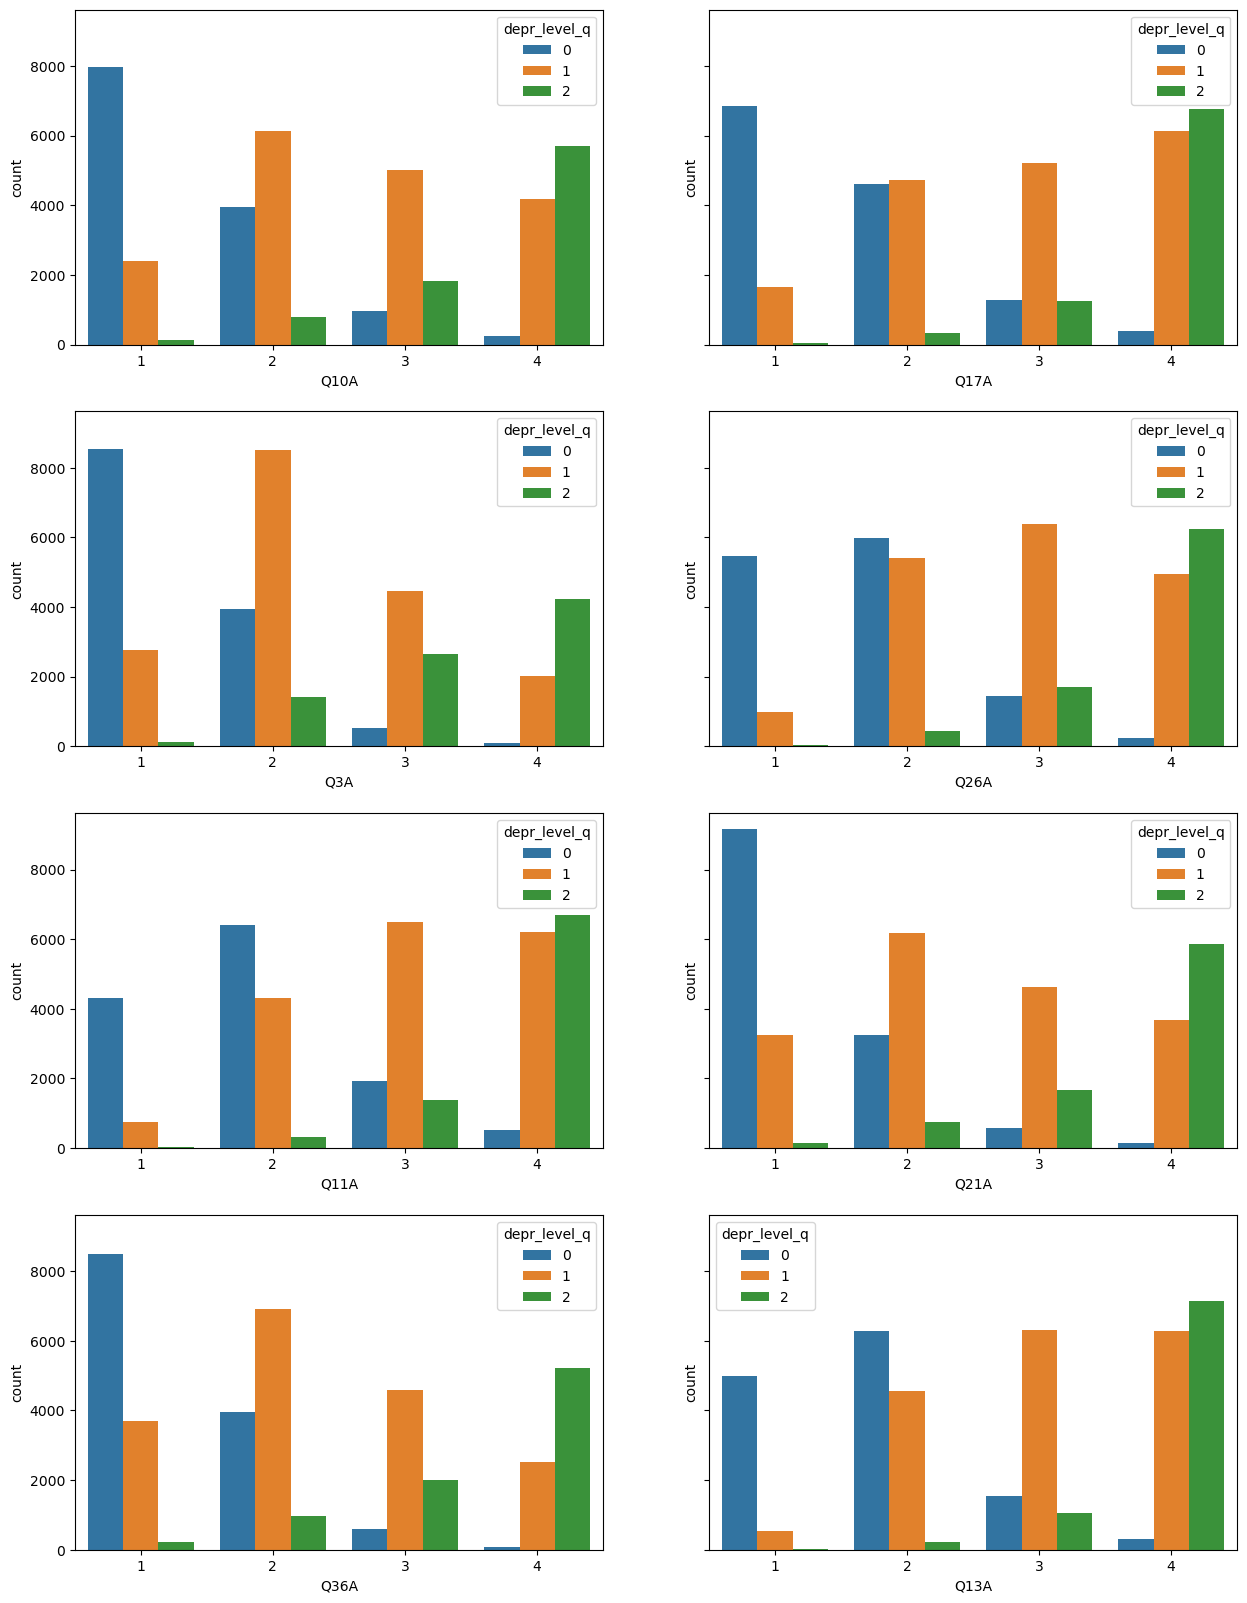

In [63]:
fig, ax=plt.subplots(4,2, figsize=(15,20),sharey=True)
i,j=0,0
for name in scales_q_answers1.columns[:-1]:
    sns.countplot(x=scales_q_answers1[name], hue=scales_q_answers1['depr_level_q'], ax=ax[i,j])
    i+=1
    if i==4:
        j+=1
        i=0

**Q10**	I felt that I had nothing to look forward to.
**Q17**	I felt I wasn&#39;t worth much as a person.

**Q3**	I couldn't seem to experience any positive feeling at all
**Q26**	I felt down-hearted and blue.

**Q11**	I found myself getting upset rather easily.
**Q21**	I felt that life wasn&#39;t worthwhile.

**Q36**	I felt terrified.
**Q13**	I felt sad and depressed.

Интересно, что существенное количество людей с низким уровнем депрессивности иногда чувствуют себя "грустными и депрессивными" (вопрос 13, вопрос 26 имеет похожую формулировку и ситуацию). Аналогичная ситуация в вопросе 11 скорее всего объясняется особенностями характера.

In [51]:
scales_q_answers[(scales_q_answers['Q3A']==2)&(scales_q_answers['depr_level_q']==3)][['Q10A', 'Q17A', 'Q26A', 'Q11A',\
                                                                                     'Q21A', 'Q36A', 'Q13A']].describe()

,Q10A,Q17A,Q26A,Q11A,Q21A,Q36A,Q13A
count,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000,1804.000000
mean,3.115854,3.560976,3.427938,3.672395,3.192905,3.293237,3.628049
std,0.893306,0.710547,0.728788,0.592702,0.892711,0.838573,0.625498
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
50%,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,4.000000
75%,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000


In [55]:
scales_q_answers[(scales_q_answers['Q3A']==1)&(scales_q_answers['Q13A']==4)][['Q10A', 'Q17A', 'Q26A', 'Q11A',\
                                                                                     'Q21A', 'Q36A', 'depr_level_q']].describe()

,Q10A,Q17A,Q26A,Q11A,Q21A,Q36A,depr_level_q
count,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000,740.000000
mean,2.404054,2.850000,3.006757,3.217568,2.358108,2.506757,1.672973
std,1.108576,1.100098,0.999977,0.926217,1.098715,1.110271,0.784542
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
25%,1.000000,2.000000,2.000000,3.000000,1.000000,2.000000,1.000000
50%,2.000000,3.000000,3.000000,4.000000,2.000000,2.000000,2.000000
75%,3.000000,4.000000,4.000000,4.000000,3.000000,4.000000,2.000000
max,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,3.000000


<Axes: >

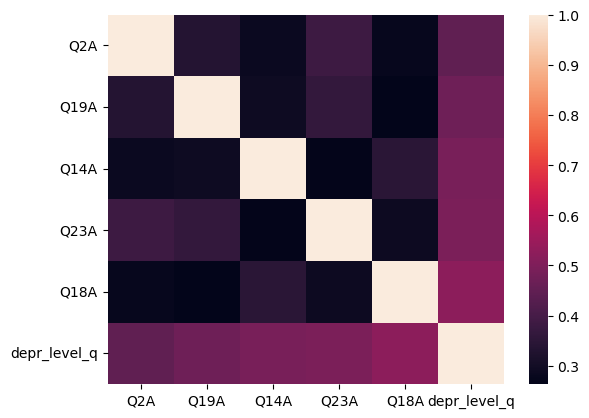

In [64]:
#less important
#b=a[:-2].sort_values()
not_important_q=b[:5].index
not_important_q=list(not_important_q)
scale_q_bad=scales_q_answers[not_important_q+['depr_level_q']]
sns.heatmap(scale_q_bad.corr())

In [65]:
#q14 (getting impatient) можно заменить остальными
#q2~q18~q19
not_important_q.remove('Q14A')
not_important_q.remove('Q18A')

In [66]:
scale_q_bad=scale_q_bad[not_important_q+['depr_level_q']]

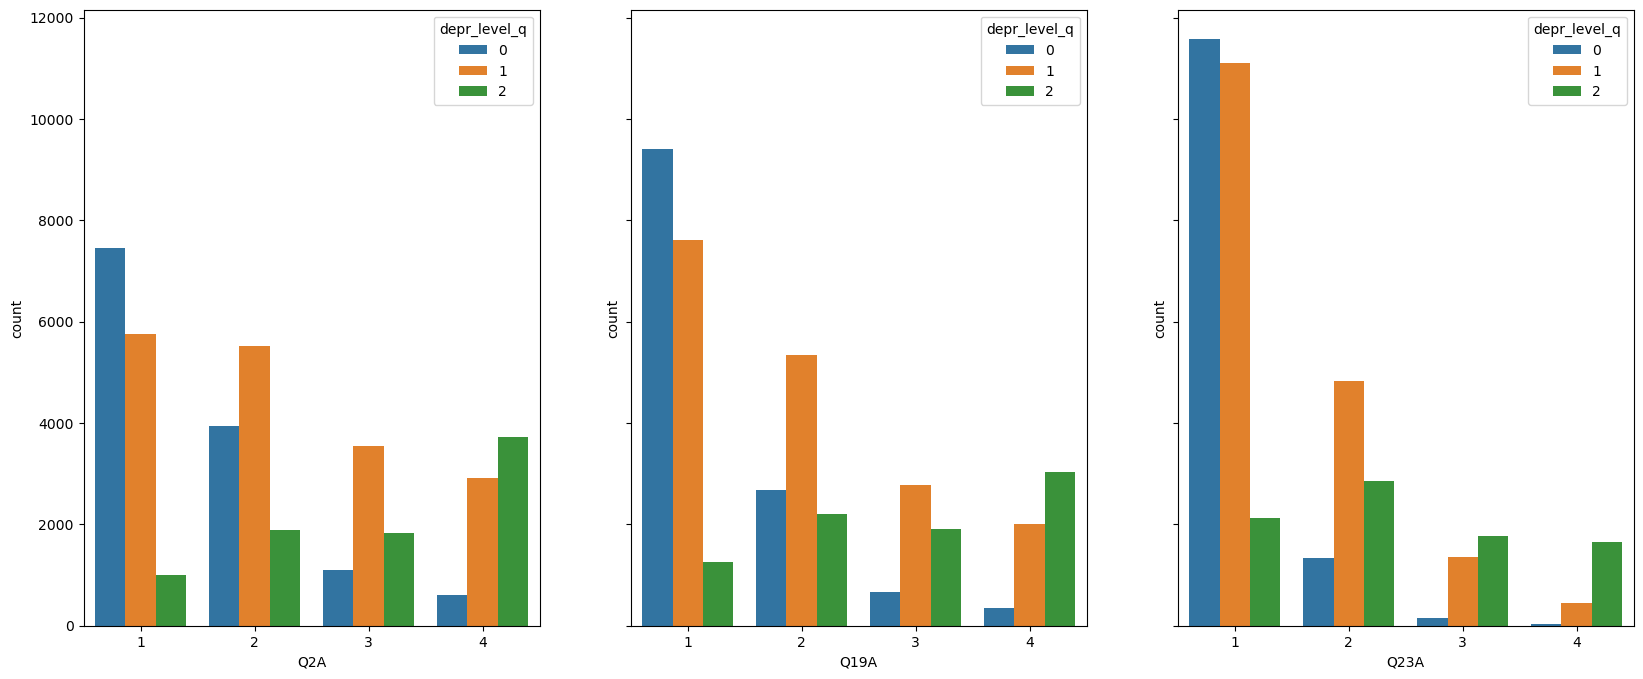

In [67]:
fig, ax=plt.subplots(1,3, figsize=(20,8), sharey=True)
i=0
for name in scale_q_bad.columns[:-1]:
    sns.countplot(x=scale_q_bad[name], hue=scale_q_bad['depr_level_q'], ax=ax[i])
    i+=1


Q2	I was aware of dryness of my mouth

Q19	I perspired noticeably (eg, hands sweaty) in the absence of high temperatures or physical exertion.

Q23	I had difficulty in swallowing.

Люди с высоким уровнем депрессии примерно с одинаковой частотой выбирают все варианты ответа (особенно на вопрос 23, где чаще всего выбирают вариант 2)

Люди с плохо выраженной депрессией почти не выбирают 4 вариант ответа (что в целом ожидаемо)

В целом вопросы касаются физических проявлений заболевания, для которых могут быть разные причины помимо психических (или как проявление тревоги или повышенного стресса, которые могут быть у людей и с, и без депрессии)

In [72]:
file1['age']=pd.cut(file1['age'], 10)

In [73]:
file1['age'].unique()[0]

Interval(12.896, 23.4, closed='right')

In [229]:
#объединить таблицы и тогда всё будет ок
for x in file1['age'].unique():
    fig=plt.figure(figsize=(10,5))
    sns.countplot(x=file1[file1['age']==x]['age'], hue=scales_q_answers['depr_level_q'])

ValueError: Length of grouper (26318) and axis (39272) must be same length

<Figure size 720x360 with 0 Axes>

__________

!!!

посмотреть зависимости депрессивности от пола, возраста, образования, религии, ориентации, семейных параметров

<AxesSubplot:xlabel='depr_level_q', ylabel='mean_time'>

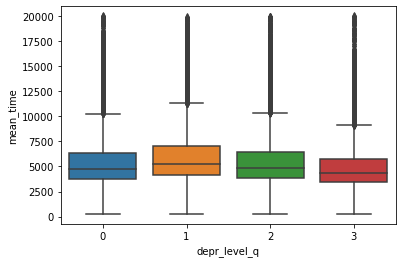

In [36]:
sns.boxplot(x='depr_level_q', y='mean_time', data=scales_q_time)

Большое количество выбросов, в среднем люди с разным уровнем депрессивности отвечают с одинаковой скоростью.

Макс время (в среднем и с учётом выбросов) показывают люди с небольшим уровнем депрессии. Возможно, они сомневаются в выборе ответа и оценке своего состояния (вроде всё не так плохо но и не так хорошо)

!!!

зависимость между тем, как похожие  люди отвечали на разные вопросы

### Анализ теста TIPI

Предлагается 10 черт характера/особенностей поведения, при этом из них можно выбрать пары попарно противоположных (1 и 6, 2 и 7, и тд). Необходимо оценить от 1 (совсем не согласен) до 7 (полностью согласен) присутствие каждой черты в себе. 

Ответы на вопросы 2, 4, 6, 8, 10 переведём к противоположным значениям: |8-ответ|

Взяв полусуммы для каждой пары, получим оценки характеристик: экстравертности, доброжелательности, осознанности, эмоциональная стабильности, открытости (новому)

In [166]:
scale_t_data.loc[:, ['TIPI'+str(i*2) for i in range(1,6)]]=8-scale_t_data.loc[:, ['TIPI'+str(i*2) for i in range(1,6)]]

D:\Users\Kate\Anaconda\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
D:\Users\Kate\Anaconda\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [167]:
scale_t_data['Extraversion']=(scale_t_data['TIPI1']+scale_t_data['TIPI6'])/2
scale_t_data['Agreeableness']=(scale_t_data['TIPI2']+scale_t_data['TIPI7'])/2
scale_t_data['Conscientiousness']=(scale_t_data['TIPI3']+scale_t_data['TIPI8'])/2
scale_t_data['Em_stability']=(scale_t_data['TIPI4']+scale_t_data['TIPI9'])/2
scale_t_data['Openness']=(scale_t_data['TIPI5']+scale_t_data['TIPI10'])/2

<ipython-input-167-61e6a12732ee>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scale_t_data['Extraversion']=(scale_t_data['TIPI1']+scale_t_data['TIPI6'])/2
<ipython-input-167-61e6a12732ee>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scale_t_data['Agreeableness']=(scale_t_data['TIPI2']+scale_t_data['TIPI7'])/2
<ipython-input-167-61e6a12732ee>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

### Анализ теста VCL

Слова, предложенные в вопросах 6, 9, 12 - несуществующие, поэтому меняем ответы на противоположные

In [149]:
scale_v_data['VCL6']=scale_v_data['VCL6'].replace({0:1, 1:0})
scale_v_data['VCL9']=scale_v_data['VCL9'].replace({0:1, 1:0})
scale_v_data['VCL12']=scale_v_data['VCL12'].replace({0:1, 1:0})

<ipython-input-149-b97dd03d928b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scale_v_data['VCL6']=scale_v_data['VCL6'].replace({0:1, 1:0})
<ipython-input-149-b97dd03d928b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scale_v_data['VCL9']=scale_v_data['VCL9'].replace({0:1, 1:0})
<ipython-input-149-b97dd03d928b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [150]:
res=scale_v_data.sum(axis=1)
res.name='result'
scale_v_data=pd.concat([scale_v_data, res], axis=1)
scale_v_data.describe()

,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,VCL7,VCL8,VCL9,VCL10,VCL11,VCL12,VCL13,VCL14,VCL15,VCL16,result
count,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000,39272.000000
mean,0.816409,0.584921,0.153774,0.871002,0.690466,0.959539,0.084157,0.170554,0.956610,0.874745,0.074430,0.915079,0.294205,0.570483,0.851548,0.935246,9.803168
std,0.387156,0.492742,0.360736,0.335202,0.462307,0.197041,0.277626,0.376124,0.203735,0.331012,0.262472,0.278767,0.455690,0.495014,0.355552,0.246094,2.702549
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,8.000000
50%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,10.000000
75%,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,16.000000


In [151]:
res2=scale_v_data['result'].apply(levels, arr=list(res.describe()[4:]))
res2.name='level_v'
scale_v_data=pd.concat([scale_v_data,res2], axis=1)
scale_v_data.head()

,VCL1,VCL2,VCL3,VCL4,VCL5,VCL6,VCL7,VCL8,VCL9,VCL10,VCL11,VCL12,VCL13,VCL14,VCL15,VCL16,result,level_v
0,1,0,0,1,1,1,1,0,1,1,0,1,0,1,1,1,11,2
1,1,1,0,1,1,1,0,0,1,1,0,1,0,1,1,1,11,2
2,1,0,0,1,1,1,0,0,1,0,1,1,0,1,1,1,10,1
3,1,0,0,1,1,1,0,0,1,1,0,1,0,1,1,1,10,1
4,1,1,0,1,1,1,0,1,1,1,0,1,1,1,1,1,13,3


#### Проверим, какие слова вызывают наибольшее/наименьшее затруднение

In [153]:
scale_v_data.corr().unstack()['result'].abs().sort_values()

VCL9       0.011442
VCL6       0.067652
VCL12      0.108715
VCL7       0.305364
VCL11      0.333470
VCL8       0.418235
VCL16      0.447174
VCL3       0.499135
VCL10      0.569151
VCL15      0.609547
VCL4       0.610190
VCL13      0.625666
VCL1       0.642739
VCL5       0.675695
VCL14      0.676572
VCL2       0.685764
level_v    0.920333
result     1.000000
dtype: float64

результат зависит в основном от 2,5,14
не особо зависит от 6,9,12

При этом несуществующие слова - 6, 9, 12

- Посмотреть зависимость этих результатов от возраста и образования

<AxesSubplot:xlabel='VCL12', ylabel='count'>

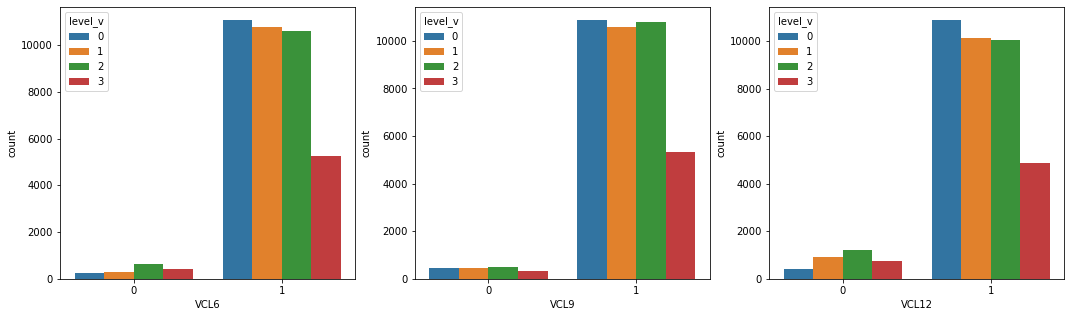

In [154]:
fig, ax=plt.subplots(1,3, figsize=(18,5))
sns.countplot(x=scale_v_data['VCL6'],hue=scale_v_data['level_v'], ax=ax[0])
sns.countplot(x=scale_v_data['VCL9'],hue=scale_v_data['level_v'], ax=ax[1])
sns.countplot(x=scale_v_data['VCL12'],hue=scale_v_data['level_v'], ax=ax[2])

cuivocal, florted, verdid

<AxesSubplot:xlabel='VCL5', ylabel='count'>

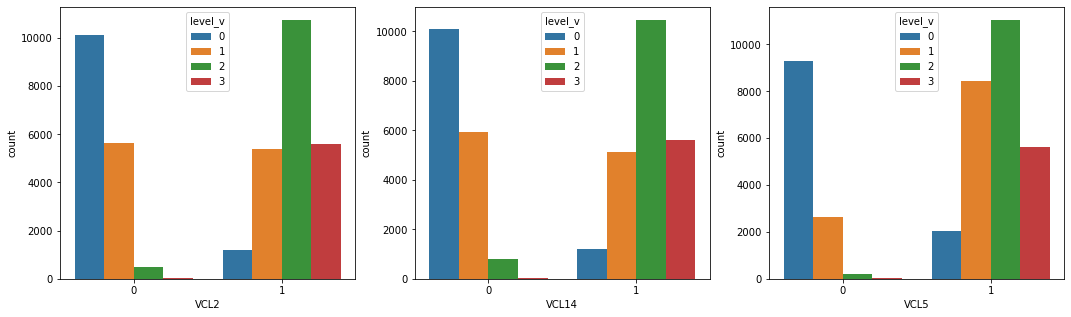

In [155]:
fig, ax=plt.subplots(1,3, figsize=(18,5))
sns.countplot(x=scale_v_data['VCL2'],hue=scale_v_data['level_v'], ax=ax[0])
sns.countplot(x=scale_v_data['VCL14'],hue=scale_v_data['level_v'], ax=ax[1])
sns.countplot(x=scale_v_data['VCL5'],hue=scale_v_data['level_v'], ax=ax[2])

3 - самые грамотные, 0 - неграмотные

### Анализ участников тестирования

Объединим персональные данные участников и их результаты тестов

In [156]:
personal_info=personal_info.merge(scale_v_data['level_v'], left_index=True,right_index=True)

In [157]:
personal_info[personal_info['level_v']==3]['age'].describe()

count    5643.000000
mean       29.602339
std        13.377205
min        13.000000
25%        19.000000
50%        25.000000
75%        37.000000
max        85.000000
Name: age, dtype: float64

In [158]:
personal_info[personal_info['level_v']==0]['age'].describe()

count    11319.000000
mean        21.972259
std          5.644230
min         13.000000
25%         19.000000
50%         21.000000
75%         24.000000
max         99.000000
Name: age, dtype: float64

<AxesSubplot:xlabel='age', ylabel='count'>

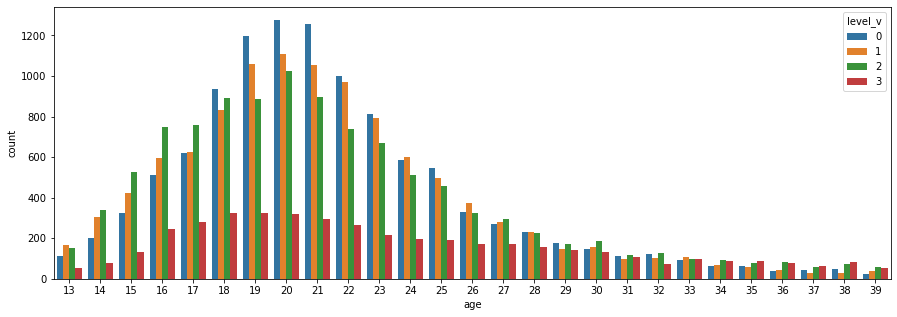

In [159]:
fig=plt.figure(figsize=(15,5))
sns.countplot(x=personal_info[personal_info['age']<40]['age'], hue=personal_info['level_v'])

<AxesSubplot:xlabel='age', ylabel='count'>

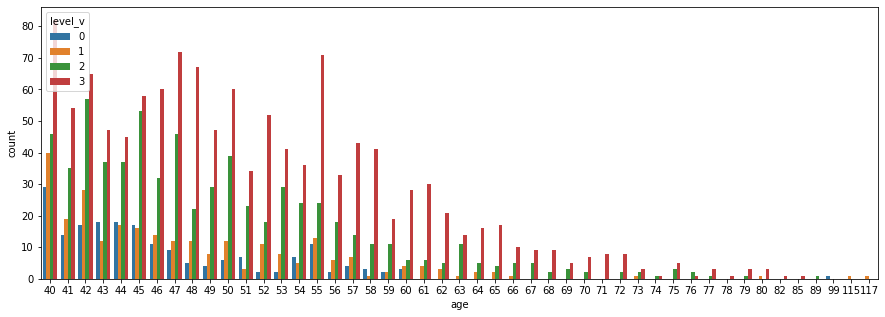

In [160]:
fig=plt.figure(figsize=(15,5))
sns.countplot(x=personal_info[personal_info['age']>=40]['age'], hue=personal_info['level_v'])

С возрастом доля "грамотных" увеличивается

In [161]:
personal_info[personal_info['age']>=40]['level_v'].value_counts(normalize=True)

3    0.521169
2    0.284505
1    0.113040
0    0.081287
Name: level_v, dtype: float64

In [162]:
personal_info[personal_info['age']<40]['level_v'].value_counts(normalize=True)

0    0.301463
1    0.292333
2    0.286670
3    0.119534
Name: level_v, dtype: float64

In [164]:
personal_info=personal_info.merge(scale_q_data['depr_level'], left_index=True,right_index=True)

In [169]:
personal_info=personal_info.merge(scale_q_data['anx_level'], left_index=True,right_index=True)
personal_info=personal_info.merge(scale_q_data['str_level'], left_index=True,right_index=True)

In [168]:
personal_info=personal_info.merge(scale_t_data[['Extraversion', 'Agreeableness','Conscientiousness',\
                                                   'Em_stability','Openness']], left_index=True,right_index=True)


<AxesSubplot:xlabel='depr_level', ylabel='count'>

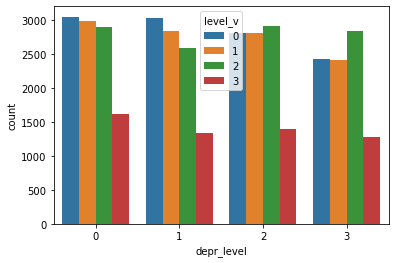

In [170]:
sns.countplot(x=personal_info['depr_level'], hue=personal_info['level_v'])

<AxesSubplot:xlabel='str_level', ylabel='count'>

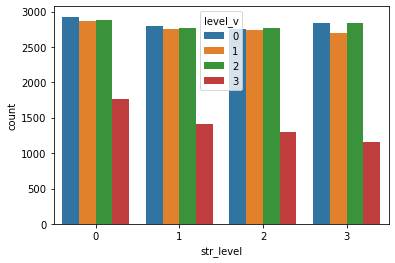

In [171]:
sns.countplot(x=personal_info['str_level'], hue=personal_info['level_v'])

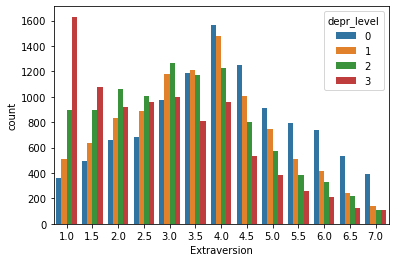

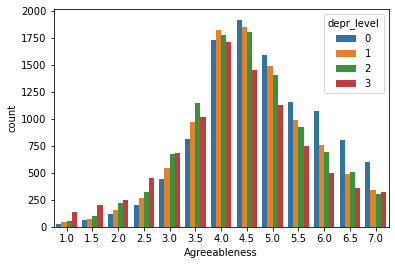

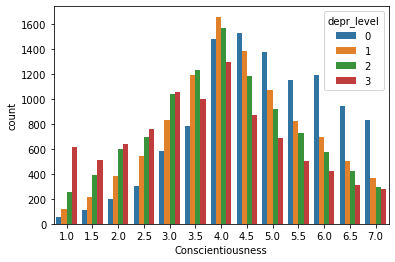

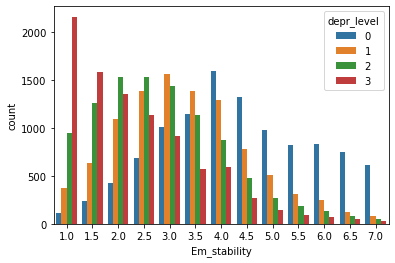

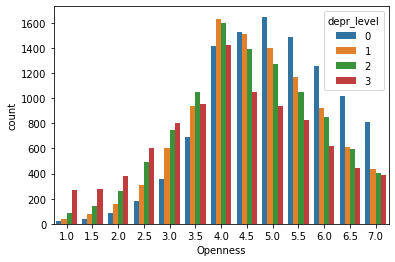

In [173]:
quality_names=['Extraversion', 'Agreeableness','Conscientiousness','Em_stability','Openness']
for i in range(5):
    fig=plt.figure()
    sns.countplot(x=personal_info[quality_names[i]], hue=personal_info['depr_level'])

Попробовать другие виды графиков??

В целом видно, что люди, оценивающие себя как замкнутые, эмоционально не стабильные, более склонны иметь выраженную депрессию

<AxesSubplot:xlabel='education', ylabel='count'>

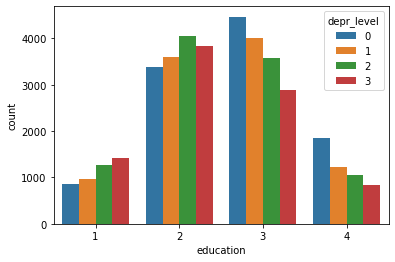

In [174]:
sns.countplot(x=personal_info['education'], hue=personal_info['depr_level'])

Среди людей с школьным образованием и ниже чаще встречаются проблемы с депрессией, чем среди людей с высшим образованием.

Сколько лет тем, у кого низкий уровень образования?

In [175]:
personal_info[personal_info['education']==1]['age'].describe()

count    4541.000000
mean       17.403435
std         6.913227
min        13.000000
25%        15.000000
50%        16.000000
75%        17.000000
max       115.000000
Name: age, dtype: float64

В основном люди, не окончившие старшую школу - школьники, часть из которых её не поступала туда(наверное)

In [176]:
personal_info[personal_info['education']==2]['age'].describe()

count    14865.000000
mean        21.316112
std          7.766124
min         13.000000
25%         18.000000
50%         19.000000
75%         21.000000
max        117.000000
Name: age, dtype: float64

В основном люди, окончившие только старшую школу, по возрасту подходят под студентов

In [108]:
personal_info[(personal_info['education']==1)&(personal_info['age']>17)]['age'].describe()

count    851.000000
mean      26.905993
std       11.712059
min       18.000000
25%       19.000000
50%       23.000000
75%       29.500000
max      115.000000
Name: age, dtype: float64

In [109]:
personal_info[(personal_info['education']==2)&(personal_info['age']>21)]['age'].describe()

count    3574.000000
mean       30.881365
std        10.980120
min        22.000000
25%        23.000000
50%        26.000000
75%        35.000000
max       117.000000
Name: age, dtype: float64

In [114]:
file1['country'].value_counts()

MY    21223
US     8161
GB     1174
CA      973
ID      873
      ...  
IM        1
KY        1
AW        1
SR        1
VC        1
Name: country, Length: 145, dtype: int64

Особенно много студентов из Маллазии, также существенная доля - из США, Великобритании

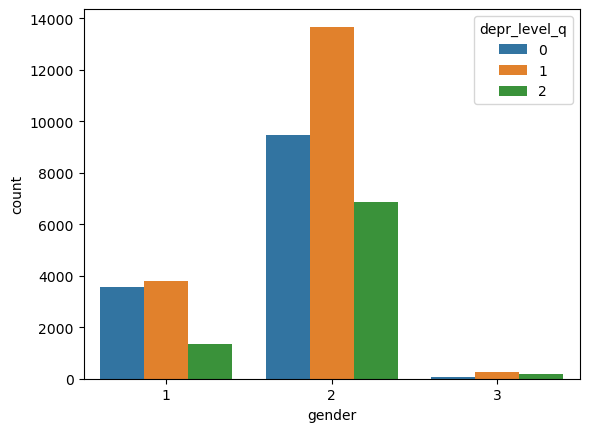

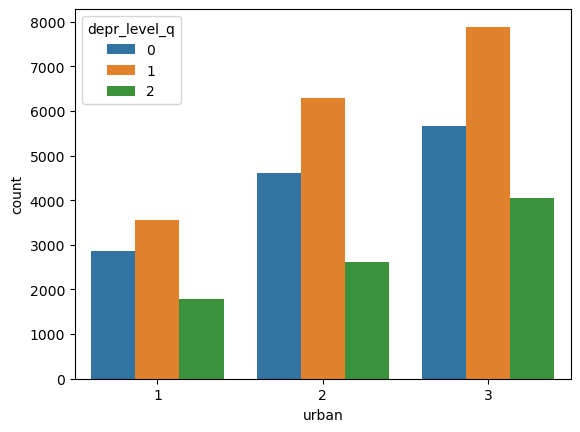

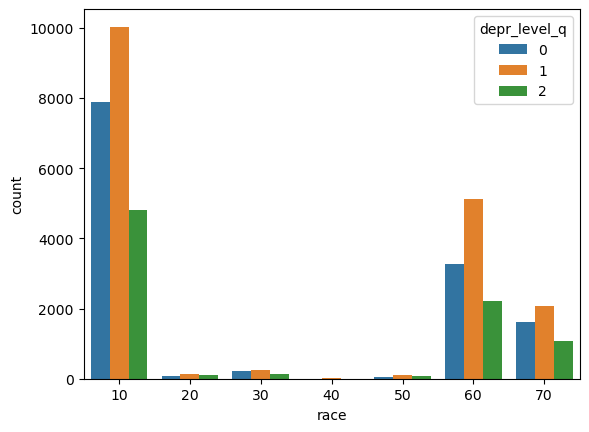

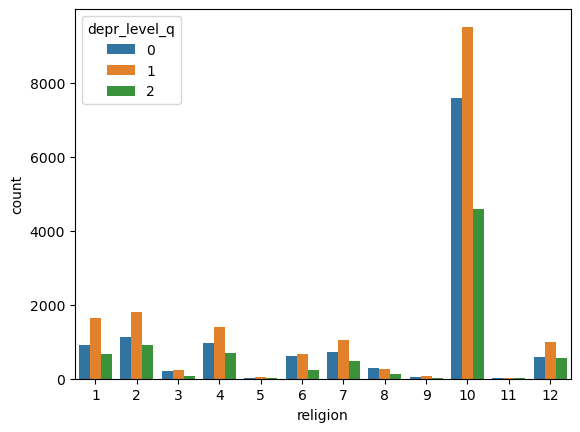

In [126]:
names=['gender', 'urban', 'race','religion']
for x in names:
    fig=plt.figure()
    sns.countplot(x=personal_info[x], hue=personal_info['depr_level_q'])

Так как большая часть учатников опроса проживают в Маллазии, не удивительно, что преобрадающая раса - азиаты, а религия - мусульмане. 


In [134]:
for x in list(personal_info['religion'].unique()):
    print(x, personal_info[personal_info['religion']==x]['depr_level_q'].value_counts(normalize=True)[2])

12 0.2604411074612858
7 0.20831470719713902
4 0.22756827048114434
10 0.2112812471174246
2 0.23825678496868477
6 0.1594014313597918
1 0.2089644513137558
8 0.19593613933236576
3 0.16159695817490494
5 0.256198347107438
11 0.25
9 0.15492957746478872


In [135]:
for x in list(personal_info['religion'].unique()):
    print(x, personal_info[personal_info['religion']==x]['depr_level_q'].value_counts(normalize=True)[0])

12 0.2731112153918348
7 0.32051855163164955
4 0.31697009102730817
10 0.34973710912277467
2 0.29097077244258873
6 0.4066363044892648
1 0.28531684698608967
8 0.4034833091436865
3 0.41254752851711024
5 0.2727272727272727
11 0.296875
9 0.33098591549295775


In [124]:
personal_info[personal_info['gender']==2]['depr_level_q'].value_counts(normalize=True)

1    0.455387
0    0.315786
2    0.228827
Name: depr_level_q, dtype: float64

In [125]:
personal_info[personal_info['gender']==1]['depr_level_q'].value_counts(normalize=True)

1    0.43590
0    0.40847
2    0.15563
Name: depr_level_q, dtype: float64

Среди мужчин доля людей с выраженной депрессией (15.5%) меньше, чем в случае с женщинами (22%)

Также среди мужчин больше людей в норме (40%), чем среди женщин (31%)

Посмотреть, на какие вопросы мужчины и женщины отвечают по-разному или чаще выбирают 4

<Axes: >

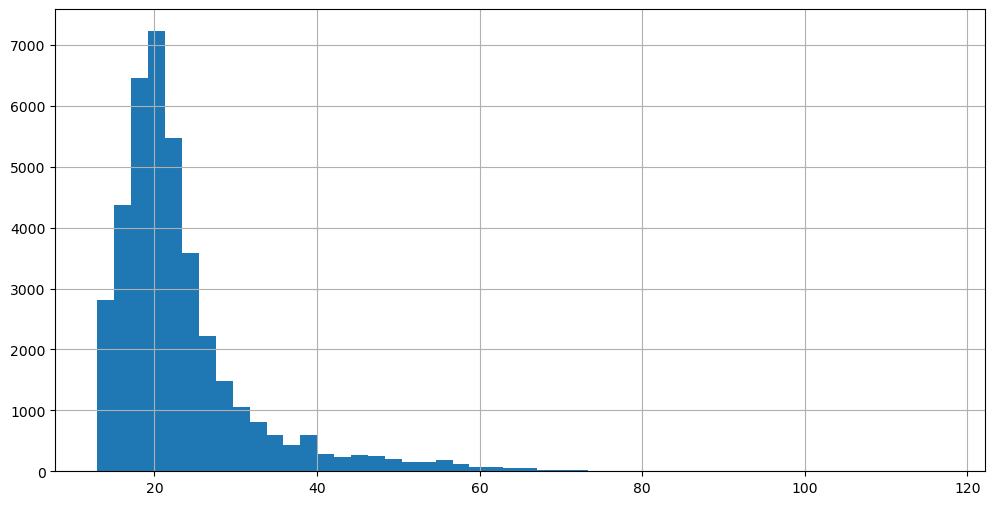

In [35]:
fig=plt.figure(figsize=(12,6))
file1['age'].hist(bins=50)